# Data Cleaning Pipeline to Remove Duplicates in FourSquare Place Dataset

In [1]:
# imports and packages
# please install these in your conda environment if they do not exist already
from sklearn.neighbors import BallTree
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
!pip install networkx
import networkx as nx
!pip install python-geohash
import geohash

from geopy.distance import geodesic

!pip install rapidfuzz
from rapidfuzz import process,fuzz
from rapidfuzz.fuzz import partial_ratio
from shapely.geometry import Point
import duckdb
import aiohttp
import asyncio
import nest_asyncio
nest_asyncio.apply()
import re
from shapely import wkt

### Data Setup

In [10]:
### PULL DATA FROM FOURSQUARE API

# # Manhattan bounding box
# manhattan_min_lon = -74.03
# manhattan_max_lon = -73.92
# manhattan_min_lat = 40.70
# manhattan_max_lat = 40.88

# s3_path = "s3://fsq-os-places-us-east-1/release/dt=2025-06-10/places/parquet/*.parquet"

# # Connect to DuckDB
# conn = duckdb.connect()

# # Query POIs within Manhattan bounds
# copy_query = f"""
#     COPY (
#         SELECT *
#         FROM read_parquet('{s3_path}')
#         WHERE 
#             longitude BETWEEN {manhattan_min_lon} AND {manhattan_max_lon}
#             AND latitude BETWEEN {manhattan_min_lat} AND {manhattan_max_lat}
#     ) TO '/share/garg/wildfires/data/manhattan_places.parquet' (FORMAT PARQUET)
# """

# conn.execute(copy_query)

# # Load the result into a dataframe
# q = duckdb.connect()
# q.execute("SELECT * FROM '/share/garg/wildfires/data/manhattan_places.parquet'")
# man_df = q.fetch_df()

# conn.close()
# q.close()

# from shapely.ops import unary_union

# county = gpd.read_file('/share/garg/accessgaps2024/fsq_cleaning/tl_2024_us_county/tl_2024_us_county.shp')
# county
# # Filter to only the 5 NYC counties by GEOID
# nyc_county_geoids = ["36005", "36047", "36061", "36081", "36085"]
# nyc = county[county["GEOID"].isin(nyc_county_geoids)].to_crs("EPSG:4326")
# nyc_geom = unary_union(nyc['geometry'])

# # Get WKT (Well-Known Text) for DuckDB
# nyc_wkt = nyc_geom.wkt

# s3_path = "s3://fsq-os-places-us-east-1/release/dt=2025-06-10/places/parquet/*.parquet"

# # Connect to DuckDB
# conn = duckdb.connect()
# conn.execute("INSTALL spatial;")
# conn.execute("LOAD spatial;")


# # Register the WKT as a geometry in DuckDB
# conn.execute("CREATE TEMP TABLE nyc_bounds AS SELECT ST_GeomFromText(?) AS geom", [nyc_wkt])

# # Now do the spatial filter using the geometry column
# query = f"""
# COPY (
#     SELECT *
#     FROM read_parquet('{s3_path}'),
#          nyc_bounds
#     WHERE ST_Contains(nyc_bounds.geom, ST_Point(longitude, latitude))
# ) TO '/share/garg/wildfires/data/nyc_places.parquet' (FORMAT PARQUET)
# """
# conn.execute(query)

# # Load the result into a dataframe
# q = duckdb.connect()
# q.execute("SELECT * FROM '/share/garg/wildfires/data/nyc_places.parquet'")
# nyc_df = q.fetch_df()

# conn.close()
# q.close()

In [2]:
def extract_top_category(cat_array):
    """
    Returns the top-level category of a single 'fsq_category_label' entry within a POI row.
    If cat_array is not an np.ndarray or is an empty np.ndarray, then returns ''

    Parameters:
        cat_array (np.ndarray): array of string category labels, where each label is broken into hierarchical subcategories using '<'/
    Returns: a string representing the top-level category of a label
    """
    if isinstance(cat_array, np.ndarray) and len(cat_array) > 0:
        return cat_array[0].split(' > ')[0].strip()
    else:
        return ''
    
# def extract_subcategory(cat_array, furthest_sub):
#     """
#     Returns the top-level category of a single 'fsq_category_label' entry within a POI row.
#     If cat_array is not an np.ndarray or is an empty np.ndarray, then returns ''

#     """
#     if isinstance(cat_array, np.ndarray) and len(cat_array) > 0:
#         return cat_array[0].split(' > ')[0:furthest_sub].strip()
#     else:
#         return ''

# 
man_df = pd.read_parquet('/share/garg/wildfires/data/manhattan_places.parquet')
man_df['geometry'] = man_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
man_df['top_category'] = man_df['fsq_category_labels'].apply(extract_top_category)

gdf = gpd.GeoDataFrame(man_df, geometry='geometry', crs="EPSG:4326")
gdf['date_created'] = pd.to_datetime(gdf['date_created'], errors='coerce')
gdf['date_closed'] = pd.to_datetime(gdf['date_closed'], errors='coerce')

nyc_df = pd.read_parquet('/share/garg/wildfires/data/nyc_places.parquet')
nyc_df = nyc_df.drop(columns = ['geom_1'])
nyc_df['geometry'] = nyc_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
nyc_df['top_category'] = nyc_df['fsq_category_labels'].apply(extract_top_category)
nyc_gdf = gpd.GeoDataFrame(nyc_df, geometry='geometry', crs="EPSG:4326")
nyc_gdf['date_created'] = pd.to_datetime(nyc_gdf['date_created'], errors='coerce')
nyc_gdf['date_closed'] = pd.to_datetime(nyc_gdf['date_closed'], errors='coerce')

zcta = gpd.read_file('/share/garg/accessgaps2024/fsq_cleaning/data/tl_2020_us_zcta520/tl_2020_us_zcta520.shp')
zcta = zcta.to_crs("EPSG:4326")  # ensure same CRS

def filter_by_zcta(gdf, zcta, zcta_codes):
    """
    Filters the GeoDataFrame [gdf] to include only POIs within the specified ZCTA code.
    
    Parameters:
        gdf (gpd.GeoDataFrame): GeoDataFrame containing POIs with 'geometry' column.
        zcta (gpd.GeoDataFrame): GeoDataFrame containing ZCTA polygons.
        zcta_code (str): The ZCTA code to filter by.
    
    Returns:
        gpd.GeoDataFrame: Filtered GeoDataFrame containing only POIs within the specified ZCTA.
    """

    # Make sure both CRS's are EPSG:4326 (meters)
    gdf = gdf.to_crs(epsg=4326)
    zcta = zcta.to_crs(epsg=4326)
    zcta_filtered = zcta[zcta['ZCTA5CE20'].isin(zcta_codes)]
    return gpd.sjoin(gdf, zcta_filtered, predicate = 'within')

### Helper Functions

In [4]:
import re
import unicodedata

def capitalize_str(name):
    parts = name.split()
    upper = [p.capitalize() for p in parts]
    return " ".join(upper)

def clean_name(name, lower = False):
    if not isinstance(name, str):
        return ""
    # Collapse multiple spaces
    name = re.sub(r'\s+', ' ', name).strip()
    # Remove accents/diacritics (e.g. é → e)
    name = unicodedata.normalize('NFKD', name).encode('ascii', 'ignore').decode()

    # Replace punctuation/symbols with space
    name = re.sub(r'[^a-zA-Z0-9\s]', ' ', name)
    return name.lower() if lower else name

GLOBAL_FOOD = {"pizza", "pizzeria", "cafe", "caffe", "coffee", "grill", "restaurant", "bar", "deli", "bakery", "express",
                  "market", "shop", "mart", "store", "grocery", "supermarket", "food", "gourmet", "cart", "fresh", "kitchen", 
                  "diner", "pub", "bistro", "tavern", "farm", "chicken", "burger", "sandwich", "taco", "tacos", "sushi", "noodle", "noodles"
                  "salad", "sub", "ice cream", "dessert", "breakfast", "brunch", "lunch", "dinner", "takeout", "delivery", 
                  "snack", "chocolate", "tea", "juice", "smoothie", "wine", "beer", "cocktail", "brewery", "distillery", 
                  "winery", "patisserie", "pastry", "bagel", "donut", "pancake", "waffle", "crepe", "treat", "cuisine", "truck",
                  "italian", "mexican", "chinese", "japanese", "korean", "indian", "thai", "vietnamese", "greek", "spanish",
                  "french", "american", "cuban", "cajun", "creole", "soul food", "bbq", "steakhouse", "seafood",
                  "vegetarian", "vegan", "gluten-free", "organic", "local", "artisan", "handmade", "craft", "homemade",
                  "family-owned", "authentic", "traditional", "fusion", "gastro", "gastropub", "halal", "kosher"}
GLOBAL_TRANS_ADDR = {"east", "west", "north", "south", "st", "street", "ave", "avenue", 
                 "blvd", "road", "rd", "rd.", "drive", "cab", "car", "truck", "van", "taxi", "metro", "sub", "subway", "mta", "station", "apt", "apartment", "station", "corner", "bus", "express", "line", "line", "plaza", "plz", "square", "sq", "lane", "ln", "way", "wy", "court", "ct",
                 "park", "pl", "pkwy", "parkway", "circle", "cir", "highway", "hwy", "route", "rte", "exit", "exit", "bridge", "bridges", "crossing", "crossings",
                 "crossings", "intersection", "intersections", "boulevard", "boulevards", "roadway", "roadways", "driveway", "driveways","avenue", "avenues", "streetway"}
GLOBAL_LOC = {"city", "village", "town", "museum", "group", "house", "center", "ctr", "art", "shop", "show", "theatre", "theater", "office", "service", "services", "bank", "jewelry", "club", 
              "community", "garden", "park", "field", "beach", "ocean", "river", "playground", "school", "college", "university", "library", "gallery", "studio", "hall", "auditorium", "venue", "church"
              "cleaner", "cleaners", "laundry", "laundromt", "pharmacy", "church", "clinic", "gym", "hospital", "fitness", "nail", "nails", "salon", "spa", "barber", "project", "projects"}
GLOBAL_WORDS = {"the", "a", "an", "and", "&", "of", "in", "for", "to", "at", "@", "on", "out", "with", "by", "from", "as", "that", "this", "it", "is", "was", "be", "are", "day", "care", "co."}
GLOBAL_SCHOOL_WRDS = {"high", "middle", "elementary", "school", "academy", "charter", "magnet", "daycare", "day", "care"}
GLOBAL_FIRE_STATION = {"fdny", "engine", "ems", "rescue", "group"}
GLOBAL_POLICE_STATION = {"nypd"}
LOCAL_PHRASES_NYC = {"new", "york", "nyc", "manhattan", "brooklyn", "queens", "bronx", "staten", "island", "ny", "city", "upper", "lower", "side", "marks"}
COMMON_PHRASES = GLOBAL_FOOD.union(GLOBAL_TRANS_ADDR).union(GLOBAL_LOC).union(GLOBAL_WORDS).union(LOCAL_PHRASES_NYC).union(GLOBAL_SCHOOL_WRDS).union(GLOBAL_FIRE_STATION).union(GLOBAL_POLICE_STATION)

# # Neighborhood and local area terms to ignore during name normalization
LOCAL_AREAS_NYC = [

    # Lower Manhattan / East Side
    "alphabet", "lower", "west", "north", "east", "south", "street", "side", "les",
    "two", "bridges", "chinatown", "nolita", "soho", "noho", "little", "italy",
    "bowery", "seaport", "civic", "center", "marks", "wall", "financial", "tribeca", "fidi", "delancey",
    "clinton", "canal",
    
    # Midtown / Gramercy / Chelsea
    "gramercy", "flatiron", "murray", "midtown",
    "koreatown", "garment", "district", "nomad", "chelsea", "hell", "hells",
    "hudson", "yards", "theater", "times", "square", "rockefeller", "kips", "turtle", "bay", "herald", "penn", "station", "empire",
    
    # Upper Manhattan
    "upper", "harlem", "spanish", "heights",
    "morningside", "hamilton", "inwood", "washington","manhattenville", "sugar", "hill", "dyckman", "fort", "george", "columbia",
    
    # Downtown / River Areas / Parks
    "tompkins", "river", "park",
    "stuytown", "stuyvesant", "oval", "union",
    "madison", "bryant", "central", "battery", "riverside", "fdr", "drive",
    
    # Outer Boroughs or Bordering Areas
    "brooklyn", "queens", "bushwick", "greenpoint", "williamsburg", "bed-stuy",
    "dumbo", "long island city", "astoria", "ridgewood",
]

NYC_BLACKLIST = COMMON_PHRASES.union(LOCAL_AREAS_NYC)

# Simple number word mappings up to 100 (expand if needed)
NUM_WORDS = {
    "zero": 0, "one": 1, "first": 1,
    "two": 2, "second": 2,
    "three": 3, "third": 3,
    "four": 4, "fourth": 4,
    "five": 5, "fifth": 5,
    "six": 6, "sixth": 6,
    "seven": 7, "seventh": 7,
    "eight": 8, "eighth": 8,
    "nine": 9, "ninth": 9,
    "ten": 10, "tenth": 10,
    "eleven": 11, "eleventh": 11,
    "twelve": 12, "twelfth": 12,
    "thirteen": 13, "thirteenth": 13,
    "fourteen": 14, "fourteenth": 14,
    "fifteen": 15, "fifteenth": 15,
    "sixteen": 16, "sixteenth": 16,
    "seventeen": 17, "seventeenth": 17,
    "eighteen": 18, "eighteenth": 18,
    "nineteen": 19, "nineteenth": 19,
    "twenty": 20, "twentieth": 20,
    "thirty": 30, "thirtieth": 30,
    "forty": 40, "fortieth": 40,
    "fifty": 50, "fiftieth": 50,
    "sixty": 60, "sixtieth": 60,
    "seventy": 70, "seventieth": 70,
    "eighty": 80, "eightieth": 80,
    "ninety": 90, "ninetieth": 90
}

def words_to_number(tokens):
    """Convert tokens like ['twenty', 'second'] → ['22']"""
    result = []
    i = 0
    while i < len(tokens):
        t = tokens[i]
        if t in NUM_WORDS:
            val = NUM_WORDS[t]
            if i + 1 < len(tokens) and tokens[i + 1] in NUM_WORDS:
                val += NUM_WORDS[tokens[i + 1]]
                i += 1
            result.append(str(val))
        else:
            result.append(t)
        i += 1
    return result

def remove_common_words(name, blacklist = NYC_BLACKLIST, rem_common_phrases = True):
    name = re.sub(r'\b(\d+)(st|nd|rd|th)\b', r'\1', name)
    parts = name.lower().split()
    parts = words_to_number(parts)

    # print("blacklist =", blacklist)
    # print("parts: " + str(parts)) 
    # global_common_words
    parts = [p for p in parts if p not in blacklist]

    # parts = [p for p in parts if p not in global_common_words]
        # p not in LOCAL_AREAS_NYC and
    return " ".join(p for p in parts if not p.isdigit() and len(p) > 1)
    
def longest_common_substring(strs, min_len = 3, blacklist = NYC_BLACKLIST):
    """
    Find the longest common substring between a list of strings.
    Parameters:
        strs (list): List of 2+ strings to compare.
    """
    assert strs is not None and len(strs) >= 2, "At least two strings are required to find a common substring."

    strs = [remove_common_words(clean_name(s, True)) for s in strs]
    # print("strs: " + str(strs))
    shortest_str = min(strs, key = len)
    longest_substring = ""

    n = len(shortest_str)
    for i in range(n):
        for j in range(i + 1, n + 1):
            substr = shortest_str[i:j]
            if all(substr in s for s in strs) and len(substr.strip()) >= min_len:
                if len(substr) > len(longest_substring):
                    longest_substring = substr.strip()
    return longest_substring

from collections import Counter
def choose_common_name_from_group(names, blacklist = NYC_BLACKLIST):
    longest_substr = longest_common_substring(names)
    if len(longest_substr) < 3 or longest_substr.lower() in NYC_BLACKLIST:
    # if len(longest_substr) < 3 or longest_substr.lower() in global_common_words:
        return None
    
    # print("longest_substr: " + longest_substr)
    lcs_tokens = longest_substr.split()
    if names:
        for n in names:
            # print("m lower: " + m)
            if remove_common_words(clean_name(n), blacklist, True) == longest_substr.lower():
                # print("m lower == longest_substr")
                return capitalize_str(n)     
        return capitalize_str(Counter(names).most_common(1)[0][0])
    else:
        return " ".join(t.capitalize() for t in lcs_tokens)


def select_most_recent_row(df):
    """
    Take the most recent row from a group of sPOIs based on 'date_refreshed' or 'date_created'.
    If 'date_refreshed' is NaN for all rows, use 'date_created' instead.
    Parameters:
        df (pd.DataFrame): DataFrame containing a group of POIs with 'date_refreshed' and 'date_created' columns.
    """
    if df['date_refreshed'].notna().any():
        return df.sort_values(by = 'date_refreshed', ascending=False).iloc[0]
    else:
        return df.sort_values(by = 'date_created', ascending=False).iloc[0]
    
def normalize_group(df, cols):
    for col in cols:
        scaler = MinMaxScaler()
        df[col + "_norm"] = scaler.fit_transform(df[col])
        # transform(lambda x: MinMaxScaler().fit_transform(x.values.reshape(-1, 1)))
    return df

def save_results_to_gdf(df, resolved_map):
    """
    Adds two new columns to [df]: 'isdup' and 'resolved_fsq_id'.
    For each row in [df], 'isdup' = True when this row is a duplicate and isdup = 0 otherwise
    For each duplicate row r in [df], 'resolved_fsq_id' maps r to its corr. row in the filtered df, that it was merged into.
    Parameters:
    df:
    dup_lst:
    """
    df['isdup'] = df['fsq_place_id'].isin(resolved_map.keys()).astype(bool)
    df['resolved_fsq_id'] = df['fsq_place_id'].map(resolved_map)
    # update for kept rows in filtered df
    kept_ids = set(resolved_map.values())
    kept = df['fsq_place_id'].isin(kept_ids)
    df.loc[kept, 'isdup'] = True
    df.loc[kept, 'resolved_fsq_id'] = df.loc[kept, 'fsq_place_id']
    return df

def calculate_metrics(rows_in_group, group, category, centroid):
    # metrics
    metrics = {}

    # Number of distinct names and addresses
    metrics['n_names'] = rows_in_group['name'].nunique()
    metrics['n_addresses'] = rows_in_group['address'].nunique()


    # Dominant name and address ratio (safe version)
    name_counts = rows_in_group['name'].value_counts(normalize=True)
    metrics['dominant_name_ratio'] = name_counts.iloc[0] if not name_counts.empty else None

    addr_counts = rows_in_group['address'].value_counts(normalize=True)
    metrics['dominant_address_ratio'] = addr_counts.iloc[0] if not addr_counts.empty else None

    # Mean name similarity (pairwise)
    name_list = rows_in_group['name'].tolist()
    if len(name_list) > 1:
        name_similarities = [
            partial_ratio(a, b) for i, a in enumerate(name_list) for b in name_list[i+1:]
        ]
        metrics['mean_name_similarity'] = float(np.mean(name_similarities))
    else:
        metrics['mean_name_similarity'] = 100

    # Spatial spread
    coords = rows_in_group[['latitude', 'longitude']].values
    centroid_coords = (centroid.y, centroid.x)
    if len(coords) > 1:
        dists = [
            geodesic(coords[i], coords[j]).meters
            for i in range(len(coords)) for j in range(i+1, len(coords))
        ]
        cent_dist = [ geodesic(coords[i], centroid_coords).meters for i in range(len(coords))]
        metrics['mean_distance_m'] = float(np.mean(dists))
        metrics['max_distance_m'] = float(np.max(dists))
        metrics['mean_cent_dist'] = float(np.mean(cent_dist))
        metrics['max_cent_distance'] = float(np.max(cent_dist))
    
    else:
        metrics['mean_distance_m'] = 0
        metrics['max_distance_m'] = 0
        metrics['mean_cent_dist'] = 0
        metrics['max_cent_distance'] = 0

    # Date variance
    for date_col in ['date_opened', 'date_refreshed', 'date_closed']:
        if date_col in rows_in_group.columns:
            try:
                dates = pd.to_datetime(rows_in_group[date_col].dropna())
                if len(dates) > 1:
                    metrics[f'{date_col}_std_days'] = float((dates - dates.min()).dt.days.std())
                    metrics[f'{date_col}_range_days'] = int((dates.max() - dates.min()).days)
                    if metrics[f'{date_col}_std_days'] > 100:
                        print(f"{date_col}std_days: " + str(metrics[f'{date_col}_std_days']))
                    if metrics[f'{date_col}_range_days'] > 100:
                        print(f"{date_col}range_days: " + str(metrics[f'{date_col}_range_days']))

                else:
                    metrics[f'{date_col}_std_days'] = 0
                    metrics[f'{date_col}_range_days'] = 0
            except Exception:
                metrics[f'{date_col}_std_days'] = None
                metrics[f'{date_col}_range_days'] = None

    group_id = "_".join(sorted(group))
    metrics['group_id'] = group_id
    metrics['category'] = category
    metrics['group_size'] = len(group)
    print(f"Group metrics: {metrics}")
    return metrics

def visualize_metrics(file_path):
    metrics = pd.read_csv(file_path)
    # print("Metrics: ")
    # print(metrics.head())
    summary = metrics.describe(include='all')
    print("Summary: ")
    print(summary[['n_names', 'n_addresses', 'dominant_name_ratio', 'mean_name_similarity', 'mean_distance_m', 'max_distance_m', 'mean_cent_dist', 'max_cent_distance']])
    
    # Plot distribution of name similarity
    plt.figure(figsize=(8, 5))
    sns.histplot(metrics['mean_name_similarity'], bins=30, kde=True)
    plt.title("Distribution of Mean Name Similarity")
    plt.xlabel("Mean Name Similarity")
    plt.ylabel("Group Count")
    plt.show()

    # Dominant name ratio
    sns.histplot(metrics['dominant_name_ratio'], bins=30, kde=True)
    plt.title("Distribution of Dominant Name Ratio")
    plt.xlabel("Dominant Name Ratio")
    plt.show()

    # Mean pairwise distance (m) within each group
    sns.histplot(metrics['mean_distance_m'], bins=30, kde=True)
    plt.title("Distribution of Mean Distances Between POIs in a Group")
    plt.xlabel("Mean Distance (m)")
    plt.show()

    # Max pairwise distance (m) within each group
    sns.histplot(metrics['max_distance_m'], bins=30, kde=True)
    plt.title("Distribution of Max Distances Between POIs in a Group")
    plt.xlabel("Max Distance (m)")
    plt.show()

    # Group Size
    sns.histplot(metrics['group_size'], bins=30, kde=True)
    plt.title("Distribution of Group Size")
    plt.xlabel("Group Size")
    plt.show()

    # STD of date_closed
    sns.histplot(metrics['date_closed_std_days'], bins=30, kde=True)
    plt.title("Distribution of STD of Dates Closed within a Group")
    plt.xlabel("STD of Dates Closed within a Group")
    plt.show()


    # Range of date_closed
    sns.histplot(metrics['date_closed_range_days'], bins=30, kde=True)
    plt.title("Distribution of Range of Dates Closed within a Group")
    plt.xlabel("Range of Dates Closed within a Group")
    plt.show()

    # Dominant Address Ratio
    sns.histplot(metrics['dominant_address_ratio'], bins=30, kde=True)
    plt.title("Distribution of Dominant Address Ratio")
    plt.xlabel("Dominant Address Ratio")
    plt.show()

    # Num of Names
    sns.histplot(metrics['n_names'], bins=30, kde=True)
    plt.title("Distribution of Number of Distinct Names In a Group")
    plt.xlabel("Number of Distinct Names In a Group")
    plt.show()

    # Dominant Address Ratio
    sns.histplot(metrics['n_addresses'], bins=30, kde=True)
    plt.title("Distribution of Number of Unique Addresses in a Group")
    plt.xlabel("Number of Unique Addresses in a Group")
    plt.show()


### Pipeline

In [5]:
### Step 1: Geohash Assignment and Processing
# assign geohash to each POI
def assign_geohashes(df, precision=7):
    df['geohash'] = df.apply(lambda row: geohash.encode(row['latitude'], row['longitude'], precision=precision), axis=1)
    return df

# get neighboring geohashes
def get_neighboring_geohashes(hash):
    neighbors = geohash.neighbors(hash)
    # include the original geohash
    return [hash] + neighbors

### Step 2: Filtering based on Fuzzy Matching + Spatial Promixity
def group_similar_names_spatial_graph(df, tree, coords, earth_radius, max_distance, similarity_threshold=85, blacklist = NYC_BLACKLIST):
    """ 
    Parameters:
        df (DataFrame): FSQ DataFrame filtered for a specific category of POIs in a single geohash grid
    
    """
    G = nx.Graph()

    # adding all POIs as nodes
    for _, row in df.iterrows():
        G.add_node(row['fsq_place_id'], name = row['name'], lon = row['longitude'], lat = row['latitude'])

    # build edges based on spatial proximity and name similarity
    for i in range(len(df)):
        # if i not in visited:
        fsq_id_i = df.iloc[i]['fsq_place_id']
        name_i = df.iloc[i]['name']
        indices = tree.query_radius([coords[i]], r=max_distance / earth_radius)[0]

        for j in indices:
            if j != i:
                fsq_id_j = df.iloc[j]['fsq_place_id']
                name_j = df.iloc[j]['name']
            # Calculate similarity using token sort ratio
                sim_i_j = fuzz.token_set_ratio(remove_common_words(clean_name(name_i), blacklist, False), remove_common_words(clean_name(name_j), blacklist, False))
                if sim_i_j >= similarity_threshold:
                    G.add_edge(fsq_id_i, fsq_id_j)

    # Find connected components
    groups = [g for g in list(nx.connected_components(G)) if len(g) > 1]
    return groups     

### Step 3: Process a Geohash Group
# process geohash groups
async def process_groups(gdf, hash, category_list, name_similarity_threshold, max_distance, precision=7, blacklist = NYC_BLACKLIST, resolved_map = {}, file_path = None):
    # Ensure gdf is in WGS84 for geohashing
    gdf = gdf.to_crs(epsg=4326)  
    # collect pois in the geohash and its neighbors
    neighboring_geohashes = get_neighboring_geohashes(hash)
    local_gdf = gdf[gdf['geohash'].isin(neighboring_geohashes)]
    earth_radius = 6371000  # Earth's radius (m)

    all_group_metrics = []
    # iterate over each category and update df to remove duplicates
    for category in category_list:
        # print("category: "+category)
        category_gdf = local_gdf[local_gdf['top_category'] == category].copy()
        if category_gdf.empty:
            continue

        coords = np.radians(np.array(list(zip(category_gdf.geometry.y, category_gdf.geometry.x))))
        tree = BallTree(coords, metric='haversine')
  
        # create groups of indices of POIs with similar names within a certain distance in the geohash
        sim_name_close_groups = group_similar_names_spatial_graph(category_gdf, tree, coords, earth_radius, max_distance, name_similarity_threshold, blacklist)
        # print("sim_name_close_groups: " + str(sim_name_close_groups)) if sim_name_close_groups else print("No groups")
        # input parent ids for each group in sim_name_close_groups
        # parent_ids, group_parent_dict, df_w_parent = await assign_parent_ids(category_gdf, sim_name_close_groups)

        if sim_name_close_groups:        
            # for each group of POIs with similar names,
            # if the group contains 2+ POIs with the same parent id, combine them by centroid and keep the most frequent name
            # if the group does not have a parent id, keep the most recent POI based on 'date_refreshed' or 'date_created'
            for group in sim_name_close_groups:
                if len(group) > 1:
                    print("\nGroup:")
                    print(category_gdf[category_gdf['fsq_place_id'].isin(group)][['name']])
                    # print("addresses: " + category_gdf[category_gdf['fsq_place_id'].isin(group)][['address']])
                    
                    rows_in_group = category_gdf[category_gdf['fsq_place_id'].isin(group)]
                    latitude = rows_in_group['latitude'].mean()
                    longitude = rows_in_group['longitude'].mean()
                    centroid = Point(longitude, latitude)

                    # metrics
                    all_group_metrics.append(calculate_metrics(rows_in_group, group, category, centroid))
                    # for i, row in rows_in_group.iterrows():
                        # print("name: " + str(row['name']) + ", website: " + str(row['website']) + ", email: " + str(row['email']) + ", date_closed: " + str(row['date_closed']))
                    names = [n for n in rows_in_group['name'].tolist()]
                    
                    # common_name = longest_common_substring(names) 
                    common_name = choose_common_name_from_group(names, blacklist)
                    if common_name is None:
                        print("No common name found for group, skipping...")
                        continue
                        
                    most_recent_row = select_most_recent_row(rows_in_group)
                    print("most recent name: "+ most_recent_row['name'])

                    # id to keep
                    most_recent_row_id = most_recent_row['fsq_place_id'] if isinstance(most_recent_row, pd.Series) else most_recent_row.iloc[0]['fsq_place_id']

                    # update resolved_map ({discarded_id: kept_id}) for this group  
                    for row in group:
                        resolved_map[row] = most_recent_row_id

                    # index to keep in original df
                    # gdf.index.get_loc(gdf[gdf['fsq_place_id'] == most_recent_row_id].index[0])
                    most_recent_label_index = gdf[gdf['fsq_place_id'] == most_recent_row_id].index[0]
                    # print("most_recent_label_index: " + str(most_recent_label_index))
                    print("row name at that index: " + gdf.at[most_recent_label_index, 'name'])

                    # update row to keep in original gdf
                    gdf.at[most_recent_label_index, 'name'] = common_name
                    print("common_name: "+ common_name)
                    if not all(not d for d in rows_in_group['date_closed']):
                        gdf.at[most_recent_label_index, 'date_closed'] = rows_in_group['date_closed'].sort_values(ascending = False).iloc[0]

                    # parent_poi = group_parent_dict.get(tuple(group), None)
                    # if (parent_poi is not None and parent_poi != ''):
                    #     print("parent id exists!")
                    # update gdf and df with the common name and centroid
                    gdf.at[most_recent_label_index, 'latitude'] = latitude
                    gdf.at[most_recent_label_index, 'longitude'] = longitude
                    gdf.at[most_recent_label_index, 'geometry'] = centroid
                    print("crs: " + str(gdf.crs))
                    # print("group fsq_ids: " + str(group))
                    # print("most_recent_row_id: " + most_recent_row_id)
                    drop_ids = set(group) - {most_recent_row_id}
                    # print("drop_ids: " + str(drop_ids))
                    gdf = gdf[~gdf['fsq_place_id'].isin(drop_ids)]
                    # print("df size: " + str(len(gdf)))
        # print("Processed a category")
    if file_path:
        metrics_df = pd.DataFrame(all_group_metrics)
        metrics_df.to_csv(file_path, index=False)
    return gdf, resolved_map

async def deduplicate(gdf, max_distance = 50, name_similarity_threshold = 80, precision = 7, blacklist = NYC_BLACKLIST, file_name = None): 
    """
    Deduplicates POIs using a grid-search technique, filtering out duplicates based on spatial proximity and fuzzy name similarity.
    
    Parameters:
        gdf (gpd.GeoDataFrame): FSQ GeoDataFrame with 'fsq_place_id', 'name', 'fsq_category_labels', 'latitude', 'longitude', date and 'geometry' columns, and more.
        max_distance (float): Maximum distance in meters for considering POIs as duplicates.
        name_similarity_threshold (int): Minimum fuzzy match ratio to consider names as duplicates.
    Returns:
        gpd.GeoDataFrame: Deduplicated POIs.
        original_saves: a copy of gdf with two additional columns: 'isdup' and 'resolved_fsq_id'. For each POI p, isdup is True if it is a duplicate 
        and resolved_fsq_id is the fsq_place_id of the kept POI in p's duplicate group. If p is not a duplicate, isdup is False and reoslved_fsq_id is None.
    """
    if gdf.empty:
        print("At least one input DataFrame is empty. Returning original df and gdf DataFrames.")
        return gdf

    gdf = gdf.to_crs("EPSG:3857")

    gdf.loc[:, 'date_created'] = pd.to_datetime(gdf['date_created'], errors='coerce')
    gdf.loc[:, 'date_closed'] = pd.to_datetime(gdf['date_closed'], errors='coerce')
    gdf.loc[:, 'date_refreshed'] = pd.to_datetime(gdf['date_refreshed'], errors='coerce')

    gdf = assign_geohashes(gdf, precision)
    gdf['parent_id'] = ''
    original = gdf.copy()
    
    gdf_list = []
    resolved_map = {}
    for hash in gdf['geohash'].unique():
        # Filter the DataFrame for the current geohash
        gdf_geohash = gdf[gdf['geohash'] == hash]
        if gdf_geohash.empty:
            continue
        
        # Get unique categories in the current geohash
        gdf_geohash['top_category'] = gdf_geohash['fsq_category_labels'].apply(extract_top_category)

        unique_top_categories = gdf_geohash['top_category'].unique().tolist()
        # Process groups for the current geohash and its categories
        processed_gdf, resolved_map = await process_groups(gdf_geohash, hash, unique_top_categories, name_similarity_threshold, max_distance, precision, blacklist, resolved_map, file_name)
        gdf_list.append(processed_gdf)

    gdf_concat = pd.concat(gdf_list, ignore_index=True)
    gdf = gpd.GeoDataFrame(gdf_concat, geometry='geometry', crs="EPSG:3857")
    original_saved = save_results_to_gdf(original, resolved_map)
    return gdf, original_saved


# Testing

In [5]:
pois_10001 = gdf[gdf['postcode'] == '10005']
dedup_10001, og_mod_10001 = await deduplicate(pois_10001, max_distance = 100, name_similarity_threshold = 90, precision = 1, blacklist = NYC_BLACKLIST)
og_mod_10001


Group:
                                        name
296909    Seastreak Ferry - Pier 11 Terminal
296914  NYC Ferry - Wall St./Pier 11 Landing
327054                    Nyc Ferry Boat H90
327055              Mcshiny (NYC Ferry Boat)
327066      NYC Ferry Boat Great Eagle HB104
327069                    Ikea Express Ferry
327071                             NYC Ferry
date_refreshedstd_days: 535.2083261506236
date_refreshedrange_days: 1212
Group metrics: {'n_names': 7, 'n_addresses': 3, 'dominant_name_ratio': np.float64(0.14285714285714285), 'dominant_address_ratio': np.float64(0.5), 'mean_name_similarity': 64.23701565020622, 'mean_distance_m': 58.4747296799468, 'max_distance_m': 107.22673156128995, 'mean_cent_dist': 39.020174244449386, 'max_cent_distance': 57.15297229262586, 'date_refreshed_std_days': 535.2083261506236, 'date_refreshed_range_days': 1212, 'date_closed_std_days': 0, 'date_closed_range_days': 0, 'group_id': '22f26a848e6d4e5d01d89d0c_4de7987e1fc7fcfe04ac252b_4fe6fbe8e4b0ed11

fsq_place_id                  name   latitude  longitude  \
19999   5b962e9f65211f002c652556       New York On Air  40.761807 -73.987286   
23613   4da71d19a86e21568172fcbf      Past 59th Street  40.769401 -73.985135   
36639   577c3812498e4378a6cd3224         1-800-POPCORN  40.777243 -73.979238   
37781   4ceaad3f8ef78cfa6e37a89b                Ichiro  40.779894 -73.975015   
41700   6449dbb4044c083c34ab0fbf  Zero Fees Processing  40.783809 -73.965901   
...                          ...                   ...        ...        ...   
328679  4d385d30fe80a1cded4a849f               Parsons  40.710181 -73.965275   
338801  4ec2db036c25adc5b2dbca7f              CLS Bank  40.741998 -73.924802   
342583  4ec8c5c94690116a8dab1012         NYC Taxi 8A28  40.763394 -73.928018   
363869  4c9147c3238c6dcb9cb1be55     Ellingson Mineral  40.793314 -73.951625   
375900  4e1cbfa16284ae9cf27e6b43          Chinese Spot  40.818789 -73.944957   

                                    address       locality region postcode  \
19999   99 Wall St #664, New York, NY 10005  New York City     NY    10005   
23613                           59th Street  New York City     NY    10005   
36639                                  None       New York     NY    10005   
37781                                  None       New York     NY    10005   
41700                        14 Wall Street      Manhattan     NY    10005   
...                                     ...            ...    ...      ...   
328679                         100 Broadway       New York     NY    10005   
338801                          32 Old Slip       New York     NY    10005   
342583                                 None       New York     NY    10005   
363869                  owner of the Gibson       New York     NY    10005   
375900                         140 Broadway       New York     NY    10005   

       admin_region post_town  ... unresolved_flags  \
19999          None      None  ...             None   
23613          None      None  ...             None   
36639          None      None  ...             None   
37781          None      None  ...             None   
41700          None      None  ...             None   
...             ...       ...  ...              ...   
328679         None      None  ...             None   
338801         None      None  ...             None   
342583         None      None  ...             None   
363869         None      None  ...             None   
375900         None      None  ...             None   

                                                     geom  \
19999   b'\x00\x00\x00\x00\x01\xc0R\x7f/\xb1\x05\xa8\x...   
23613   b'\x00\x00\x00\x00\x01\xc0R\x7f\x0cs\xbcK\x91@...   
36639   b'\x00\x00\x00\x00\x01\xc0R~\xab\xd7\x10\x03\x...   
37781   b'\x00\x00\x00\x00\x01\xc0R~f\xa5<P\xa7@Dc\xd3...   
41700   b'\x00\x00\x00\x00\x01\xc0R}\xd1S\xb8\x83"@DdS...   
...                                                   ...   
328679  b'\x00\x00\x00\x00\x01\xc0R}\xc7\x0f\xca\x16\x...   
338801  b'\x00\x00\x00\x00\x01\xc0R{/\xf5\x12\x00\xfc@...   
342583  b'\x00\x00\x00\x00\x01\xc0R{d\xa6.\x13\xef@Da\...   
363869  b'\x00\x00\x00\x00\x01\xc0R|\xe7ke\x86\xf5@De\...   
375900  b'\x00\x00\x00\x00\x01\xc0R|z-\xf6\xda\x1b@Dh\...   

                                                     bbox          dt  \
19999   {'xmin': -73.98728585770014, 'ymin': 40.761806...  2025-06-10   
23613   {'xmin': -73.98513501537515, 'ymin': 40.769400...  2025-06-10   
36639   {'xmin': -73.97923828662812, 'ymin': 40.777243...  2025-06-10   
37781   {'xmin': -73.97501498117582, 'ymin': 40.779893...  2025-06-10   
41700   {'xmin': -73.96590130823873, 'ymin': 40.783809...  2025-06-10   
...                                                   ...         ...   
328679  {'xmin': -73.96527476057996, 'ymin': 40.710180...  2025-06-10   
338801  {'xmin': -73.92480208166302, 'ymin': 40.741997...  2025-06-10   
342583  {'xmin': -73.92801813602249, 'ymin': 40.763394...  2025-06-10  

In [6]:
# og_mod_10001[(og_mod_10001['isdup'] == True) & (og_mod_10001['fsq_place_id'] != og_mod_10001['resolved_fsq_id'])]
og_mod_10001[(og_mod_10001['isdup'] == True)]

fsq_place_id                              name   latitude  \
296674  51c9a1f6498e6be2f5ca5b23                 Crystal & Company  40.703678   
296745  529e29a4498ea495fd0f76cc                      Fritesnmeats  40.704138   
296761  521b898a8bbdce5bf8e95c58                     Complete Body  40.704341   
296767  58c2e41d0393cc3be99b7a02             Frites 'n' Meats FIDI  40.704363   
296793  5601410b498e02b9722ea165                 Michael Lamonsoff  40.703791   
...                          ...                               ...        ...   
327055  5c3fa5bed0a149002c88088c          Mcshiny (NYC Ferry Boat)  40.703346   
327056  5d703db22888ba00089649f7                            Slip C  40.703141   
327066  5922157c62420b2d9ac0eb78  NYC Ferry Boat Great Eagle HB104  40.702991   
327069  58a9fca84ca49b71b4b821da                Ikea Express Ferry  40.703146   
327071  22f26a848e6d4e5d01d89d0c                         NYC Ferry  40.703249   

        longitude                                   address  locality region  \
296674 -74.008265                               32 Old Slip  New York     NY   
296745 -74.009200                               15 Broad St  New York     NY   
296761 -74.009161                             10 Hanover Sq  New York     NY   
296767 -74.008860                               15 Broad St  New York     NY   
296793 -74.008095            Financial Square - 32 Old Slip  New York     NY   
...           ...                                       ...       ...    ...   
327055 -74.005680                                      None  New York     NY   
327056 -74.005724                                      None  New York     NY   
327066 -74.005794                                      None  New York     NY   
327069 -74.006019  Pier 11, New York , 10005, United States  New York     NY   
327071 -74.006197                               110 Wall St  New York     NY   

       postcode admin_region post_town  ... unresolved_flags  \
296674    10005         None      None  ...             None   
296745    10005         None      None  ...             None   
296761    10005         None      None  ...             None   
296767    10005         None      None  ...             None   
296793    10005         None      None  ...             None   
...         ...          ...       ...  ...              ...   
327055    10005         None      None  ...             None   
327056    10005         None      None  ...             None   
327066    10005         None      None  ...             None   
327069    10005         None      None  ...             None   
327071    10005         None      None  ...             None   

                                                     geom  \
296674  b'\x00\x00\x00\x00\x01\xc0R\x80\x87kO\xae!@DZ\...   
296745  b'\x00\x00\x00\x00\x01\xc0R\x80\x96\xbbU\xf4a@...   
296761  b"\x00\x00\x00\x00\x01\xc0R\x80\x96\x16A\x17\x...   
296767  b'\x00\x00\x00\x00\x01\xc0R\x80\x91(\x90\\4@DZ...   
296793  b'\x00\x00\x00\x00\x01\xc0R\x80\x84\xa1\xec\xd...   
...                                                   ...   
327055  b'\x00\x00\x00\x00\x01\xc0R\x80]\x0f\xa5\x8fq@...   
327056  b'\x00\x00\x00\x00\x01\xc0R\x80]\xc823Y@DZ\x00...   
327066  b'\x00\x00\x00\x00\x01\xc0R\x80^\xef\xc7>\xcd@...   
327069  b'\x00\x00\x00\x00\x01\xc0R\x80b\x9c\xbd\xb9\x...   
327071  b'\x00\x00\x00\x00\x01\xc0R\x80e\x89\xef\xa1\x...   

                                                     bbox          dt  \
296674  {'xmin': -74.00826533108967, 'ymin': 40.703678...  2025-06-10   
296745  {'xmin': -74.00919993776326, 'ymin': 40.704138...  2025-06-10   
296761  {'xmin': -74.00916057926591, 'ymin': 40.704340...  2025-06-10   
296767  {'xmin': -74.0088597688453, 'ymin': 40.7043630...  2025-06-10   
296793  {'xmin': -74.00809524657687, 'ymin': 40.703790...  2025-06-10   
...                                                   ...         ...   
327055  {'xmin': -74.00568, 'ymin': 40.703346, 'xmax':...  2025-06-10   


In [82]:
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr, spearmanr
import numpy as np
from sklearn.preprocessing import StandardScaler

zips_done = [10001, 10002, 10003, 10004, 10005, 10006, 10007, 10009, 10010, 10011, 10012, 10013, 
    10014, 10016, 10017, 10018, 10019, 10021, 10023, 10024, 10025, 10026, 10027, 
    10028, 10029, 10030, 10031, 10032, 10033, 10034, 10035, 10037, 10038, 10039, 
    10040, 10044, 10069, 10103, 10119, 10128, 10162, 10165, 10170, 10173, 10199, 10279, 
    10280, 10282, 10022, 10028, 10036, 10065, 10075]

# , 10022, 10028, 10036, 10065, 10075

pop = gpd.read_file('/share/garg/dogathon/d01_data/d02_demographics/ZCTA.gpkg')
pop_man = pop[pop['ZCTA'].isin(zips_done)]
pop_man['ZCTA'] = pop_man['ZCTA'].astype(str)
pop_man = pop_man.rename(columns = {'ZCTA': 'zip'})

/share/garg/conda_virtualenvs/wildfires/lib/python3.9/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
counts_all_zips = []
for i in zips_done:
    counts_all_zips.append(pd.read_csv(f"/share/garg/accessgaps2024/fsq_cleaning/results_by_zip_{i}_cat.csv"))

df_all_zips = pd.concat(counts_all_zips, ignore_index = True)
df_all_zips = df_all_zips.groupby(by = ['zip', 'lander_category'])[['COUNT(ZBP)', 'COUNT(OG)', 'COUNT(Dedup)']].sum().reset_index()

df_all_zips['ZBP_Share'] = df_all_zips.groupby("zip")['COUNT(ZBP)'].transform(lambda x: x / x.sum() if x.sum() > 0 else 0) 
df_all_zips['OG_Share'] = df_all_zips.groupby("zip")['COUNT(OG)'].transform(lambda x: x / x.sum() if x.sum() > 0 else 0)
df_all_zips['Dedup_Share'] = df_all_zips.groupby("zip")['COUNT(Dedup)'].transform(lambda x: x / x.sum() if x.sum() > 0 else 0)


df_all_zips['zip'] = df_all_zips['zip'].astype(str).str.zfill(5)
counts_pop = df_all_zips.merge(pop_man[['zip', 'Population']], on = 'zip', how = 'left')

counts_pop['OG_Per_Capita'] = counts_pop['COUNT(OG)'] / counts_pop['Population']
counts_pop['Dedup_Per_Capita'] = counts_pop['COUNT(Dedup)'] / counts_pop['Population']
counts_pop['ZBP_Per_Capita'] = counts_pop['COUNT(ZBP)'] / counts_pop['Population']

raw_count_stats = []
for cat in counts_pop['lander_category'].unique():
    # Assume df has 'COUNT(ZBP)' and 'COUNT(Dedup)'
    cat_df = counts_pop[counts_pop['lander_category'] == cat]
    zbp = cat_df['COUNT(ZBP)']
    # og = cat_df['COUNT(OG)']
    # og_per_capita = 
    # dedup = cat_df['COUNT(Dedup)']
    cols = ['COUNT(OG)', 'COUNT(Dedup)', 'OG_Per_Capita', 'Dedup_Per_Capita']
    # cols = ['OG_Share', 'Dedup_Share']

    for col in cols:
        # Root Mean Squared Error (RMSE)
        # print("zbp: " + str(zbp))
        # print(f"cat_df[{col}]: " + str(cat_df[col]))
        rmse = np.sqrt(mean_squared_error(zbp, cat_df[col]))
        # Pearson correlation
        pearson_corr, pearson_p = pearsonr(zbp, cat_df[col])
        # Spearman correlation
        # spearman_corr, spearman_p = spearmanr(zbp, cat_df[col])

        if 'Dedup' in col:
            print("stat: " + col)
            print("dedup rmse: " + str(rmse))
            print("og rmse: " + str(raw_count_stats[-1]['RMSE']))
            rmse_red = round(rmse - raw_count_stats[-1]['RMSE'], 5)
            print("rmse red: " + str(rmse_red))

        else:
            rmse_red = 0
            
        raw_count_stats.append({"category": cat, "stat" : col,  "Pearson Correlation": pearson_corr, 'RMSE': rmse, 'RMSE_RED': rmse_red})
        # Print the results
        # print(f"Category: {cat}" )
        # print(f"RMSE between ZBP and {col} counts: {rmse:.2f}")
        # print(f"Pearson Correlation between ZBP and {col} counts: {pearson_corr:.3f} (p = {pearson_p:.3g})")
        # print(f"Spearman Correlation between ZBP and {col} counts: {spearman_corr:.3f} (p = {spearman_p:.3g})")

raw_count_stats = pd.DataFrame(raw_count_stats)
raw_count_stats[raw_count_stats['category'] != 'fire_stations']


stat: COUNT(Dedup)
dedup rmse: 136.1396341995967
og rmse: 140.04072209951593
rmse red: -3.90109
stat: Dedup_Per_Capita
dedup rmse: 26.692331651146837
og rmse: 26.69222506136226
rmse red: 0.00011
stat: COUNT(Dedup)
dedup rmse: 15.614342519225467
og rmse: 15.614342519225467
rmse red: 0.0
stat: Dedup_Per_Capita
dedup rmse: 0.0007078250923530442
og rmse: 0.0007078250923530442
rmse red: 0.0
stat: COUNT(Dedup)
dedup rmse: 9.526279441628825
og rmse: 9.9014373470957
rmse red: -0.37516
stat: Dedup_Per_Capita
dedup rmse: 4.068887634393609
og rmse: 4.068876342565011
rmse red: 1e-05
stat: COUNT(Dedup)
dedup rmse: 180.26134873054136
og rmse: 185.4863150664304
rmse red: -5.22497
stat: Dedup_Per_Capita
dedup rmse: 0.33769122037561283
og rmse: 0.3376214763274675
rmse red: 7e-05
stat: COUNT(Dedup)
dedup rmse: 17.307179479581922
og rmse: 17.569641649513166
rmse red: -0.26246
stat: Dedup_Per_Capita
dedup rmse: 3.3847949787014344
og rmse: 3.384789301227603
rmse red: 1e-05
stat: COUNT(Dedup)
dedup rmse: 17

/tmp/ipykernel_2623005/3846686713.py:42: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, pearson_p = pearsonr(zbp, cat_df[col])
/tmp/ipykernel_2623005/3846686713.py:42: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, pearson_p = pearsonr(zbp, cat_df[col])
/tmp/ipykernel_2623005/3846686713.py:42: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, pearson_p = pearsonr(zbp, cat_df[col])
/tmp/ipykernel_2623005/3846686713.py:42: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, pearson_p = pearsonr(zbp, cat_df[col])


category              stat  Pearson Correlation        RMSE  \
0           childcare         COUNT(OG)             0.702774  140.040722   
1           childcare      COUNT(Dedup)             0.706657  136.139634   
2           childcare     OG_Per_Capita            -0.161066   26.692225   
3           childcare  Dedup_Per_Capita            -0.161750   26.692332   
8   homeless_shelters         COUNT(OG)             0.351646    9.901437   
9   homeless_shelters      COUNT(Dedup)             0.324321    9.526279   
10  homeless_shelters     OG_Per_Capita             0.123244    4.068876   
11  homeless_shelters  Dedup_Per_Capita             0.110933    4.068888   
12              parks         COUNT(OG)             0.191259  185.486315   
13              parks      COUNT(Dedup)             0.183863  180.261349   
14              parks     OG_Per_Capita             0.026310    0.337621   
15              parks  Dedup_Per_Capita             0.023496    0.337691   
16   police_precincts         COUNT(OG)             0.458230   17.569642   
17   police_precincts      COUNT(Dedup)             0.452080   17.307179   
18   police_precincts     OG_Per_Capita            -0.069092    3.384789   
19   police_precincts  Dedup_Per_Capita            -0.069234    3.384795   
20    social_services         COUNT(OG)             0.541505   17.787744   
21    social_services      COUNT(Dedup)             0.545223   17.934711   
22    social_services     OG_Per_Capita            -0.147587   26.919056   
23    social_services  Dedup_Per_Capita            -0.147780   26.919075   
24   waste_management         COUNT(OG)             0.439656    9.882969   
25   waste_management      COUNT(Dedup)             0.439656    9.882969   
26   waste_management     OG_Per_Capita             0.169376    2.590292   
27   waste_management  Dedup_Per_Capita             0.169376    2.590292   

    RMSE_RED  
0    0.00000  
1   -3.90109  
2    0.00000  
3    0.00011  
8    0.00000  
9   -0.37516  
10   0.00000  
11   0.00001  
12   0.00000  
13  -5.22497  
14   0.00000  
15   0.00007  
16   0.00000  
17  -0.26246  
18   0.00000  
19   0.00001  
20   0.00000  
21   0.14697  
22   0.00000  
23   0.00002  
24   0.00000  
25   0.00000  
26   0.00000  
27   0.00000

In [84]:
lander_naics_mapping = {
   "childcare" : [6111, 624110, 624410],
   "fire_stations" : [926610],
   "police_precincts" : [922120, 561612, 928110],
   "parks" : [712190, 721211, 712130],
   "waste_management" : [5621, 5622, 5629, 924110, 562998, 221320],
    "homeless_shelters" : [624221, 624230],
    "social_services" : [621112, 621330, 621420, 6222, 6232]
}

lander_fsq_mapping = {
   "childcare" : ["Child Care Service", "Primary and Secondary School", "Preschool", "Nursery School"],
   "fire_stations" : ["Fire Station"],
   "police_precincts" : ["Police Station"],
   "parks" : ["Park"],
   "waste_management" : ["Waste Management Service", "Water Treatment Service", "Recycling Facility"],
   "homeless_shelters" : ["Homeless Shelter", 'Public and Social Service', 'Government Building', 'Organization',
                         'Community Center', 'Housing Development', 'Rehabilitation Center', 'Shelter', 'Spiritual Center',
                         'Assisted Living', 'Charity'],
   "social_services" : ["Mental Health Services", "Addiction Treatment Center", "Domestic Abuse Treatment Center", "Rehabilitation Center"]
}

def convert_prefix_to_label(mapping):
    prefix_to_label = {}
    for label, codes in mapping.items():
        for c in codes:
            prefix_to_label[str(c)] = label
    return prefix_to_label

def assign_label(naics_str, mapping):
  for code, label in convert_prefix_to_label(mapping).items():
    if naics_str.startswith(code):
      return label
  else:
     return None
  
def get_lander_category(x, mapping):
    for lander_cat, fsq_cat in mapping.items():
        for cat in fsq_cat:
            if any(cat.lower() in v.lower() for v in x):
               return lander_cat
    return None

def clean_naics(naics_str):
    # print("naics code: " + naics_str)
    match = re.match(r'^(\d{2,6})', naics_str)
    # print("match: " + str(match))
    return match.group(1) if match else ""

In [9]:
years = ['16', '17', '18', '19', '20', '21', '22']

all_zip_data = []

for y in years:
    path = f"/share/garg/accessgaps2024/d01_data/d03_Census-spatial-raw-data/zbp15-22/zbp{y}detail.txt"
    df = pd.read_csv(path, sep = ",")
    # print(df)
    df['year'] = '20' + y
    all_zip_data.append(df)

res_data = pd.concat(all_zip_data, ignore_index = True)
res_data['naics_clean'] = res_data['naics'].astype(str).apply(clean_naics)
# res_data['top_category'] = res_data['naics_clean'].apply(lambda x : assign_label(x, fsq_zbp_mapping))
res_data['lander_category'] = res_data['naics_clean'].apply(lambda x: assign_label(x, lander_naics_mapping))

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [13]:
res_data = res_data[~res_data['lander_category'].isna()]

nyc_zips = ['100', '112', '113', '114', '104', '103']

def check_if_nyc(zip):
    s = str(zip)
    return True if any(s.startswith(suff) for suff in nyc_zips) and len(s) == 5 else False
# in_nyc = any(s.startswith(suff) for suff in nyc_zips for s in res_data['zip'].astype(str))
# print(in_nyc)
res_nyc = res_data[res_data['zip'].apply(check_if_nyc)]

/share/garg/conda_virtualenvs/wildfires/lib/python3.9/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


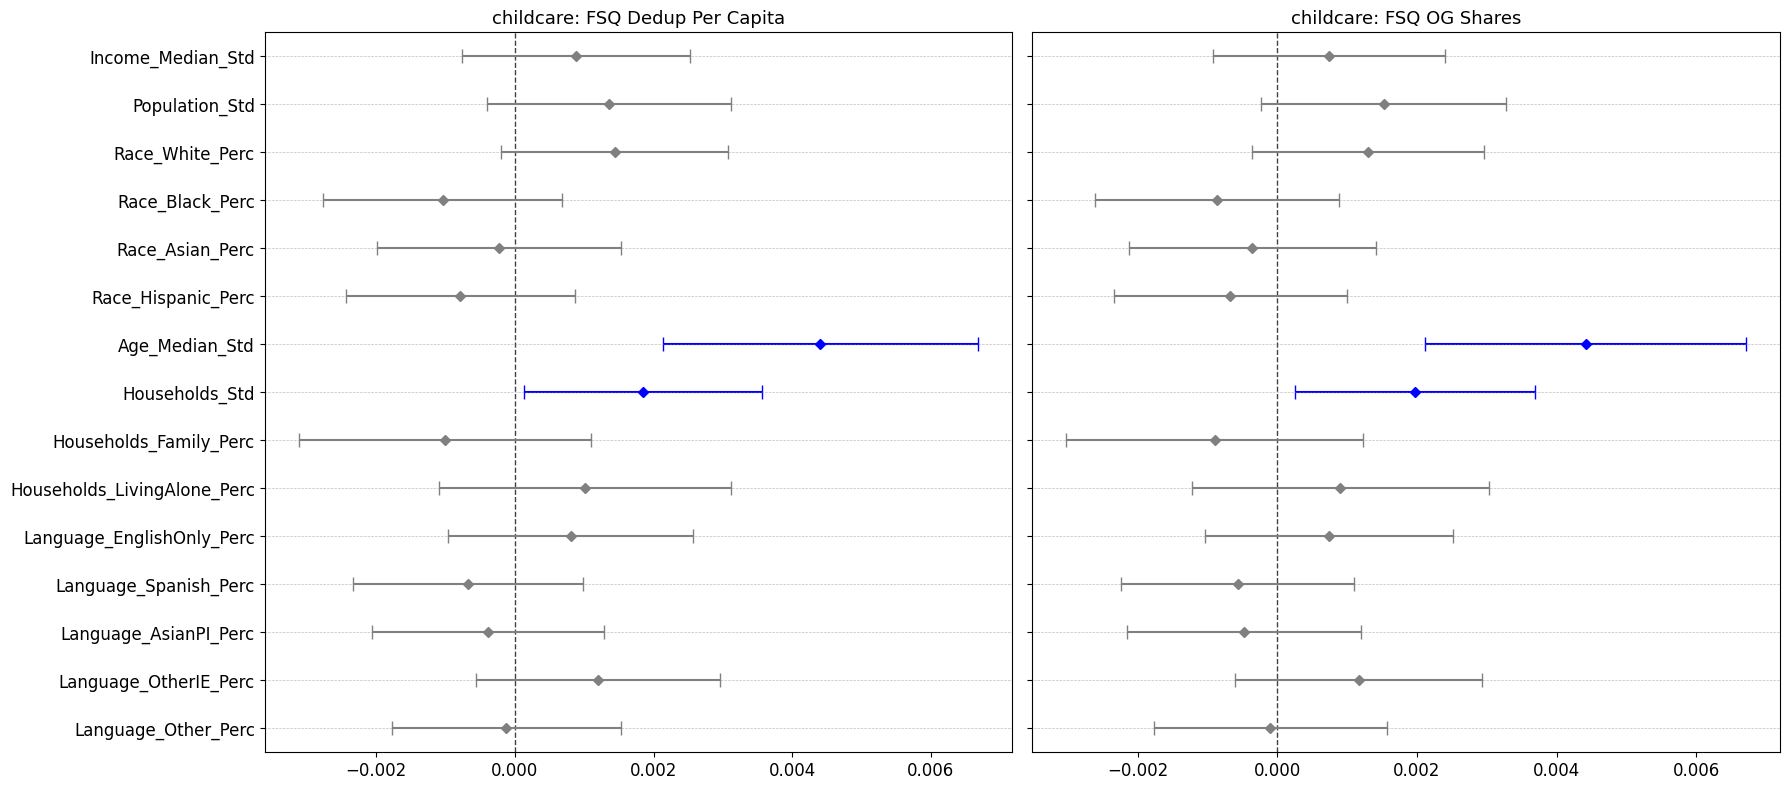

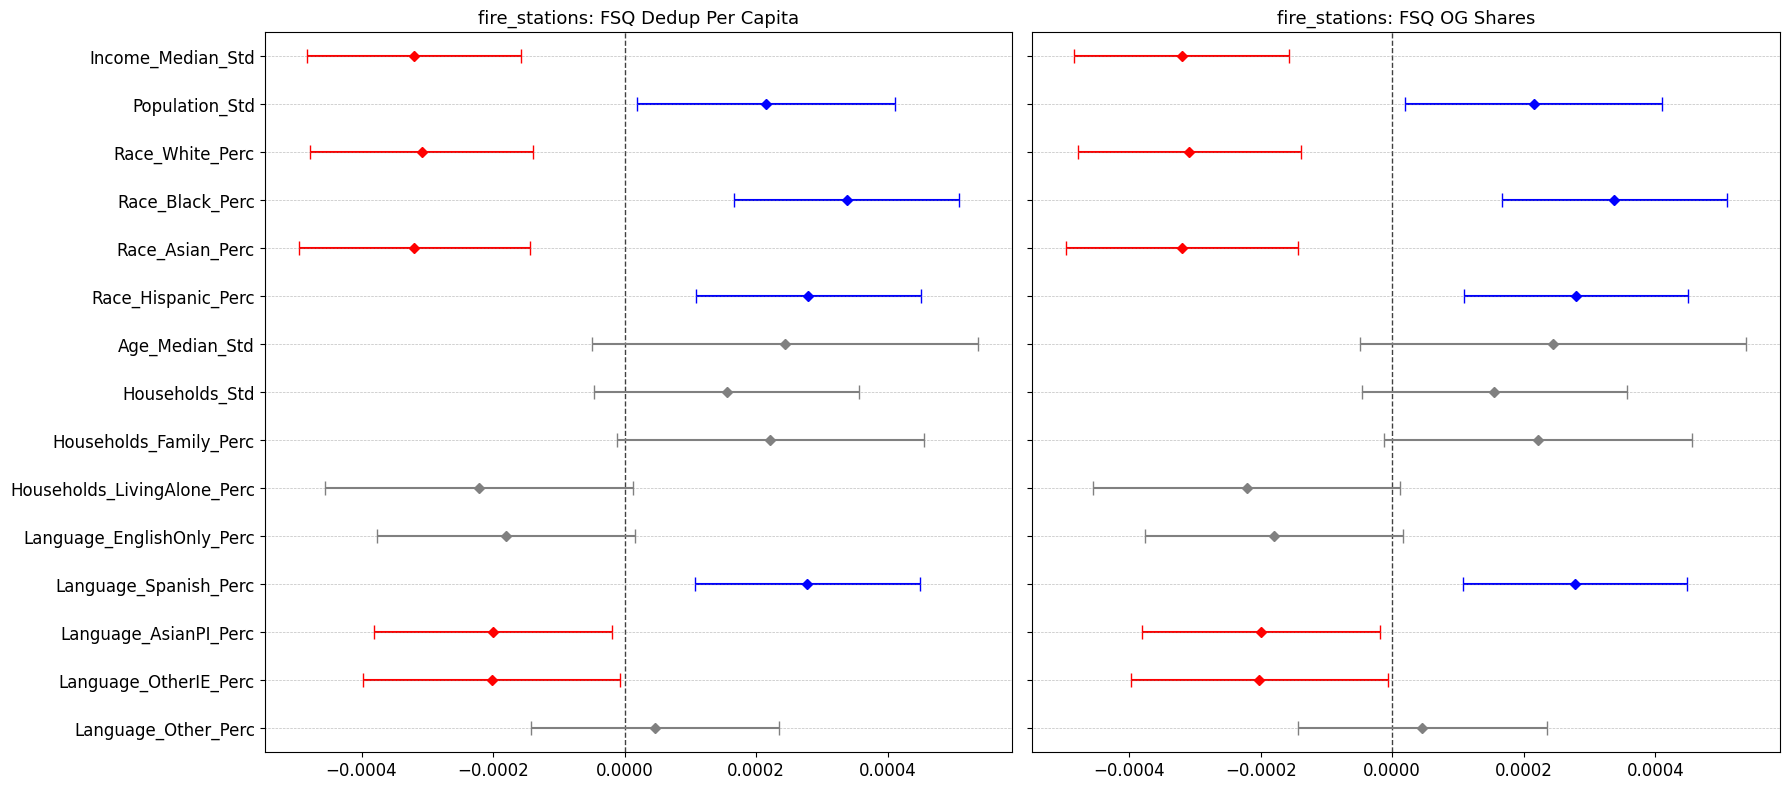

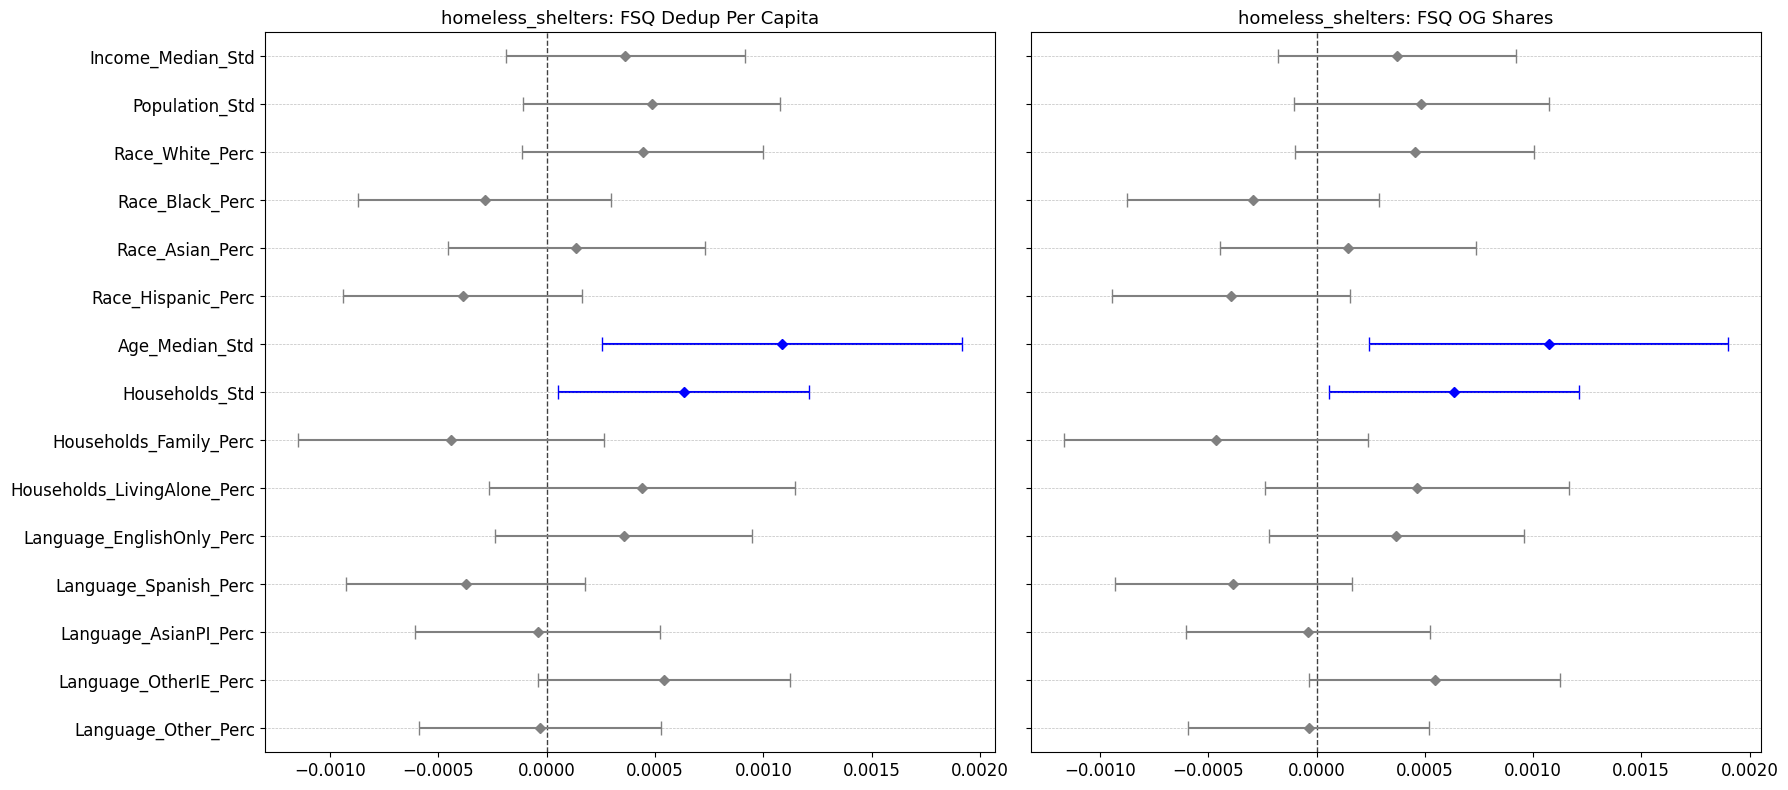

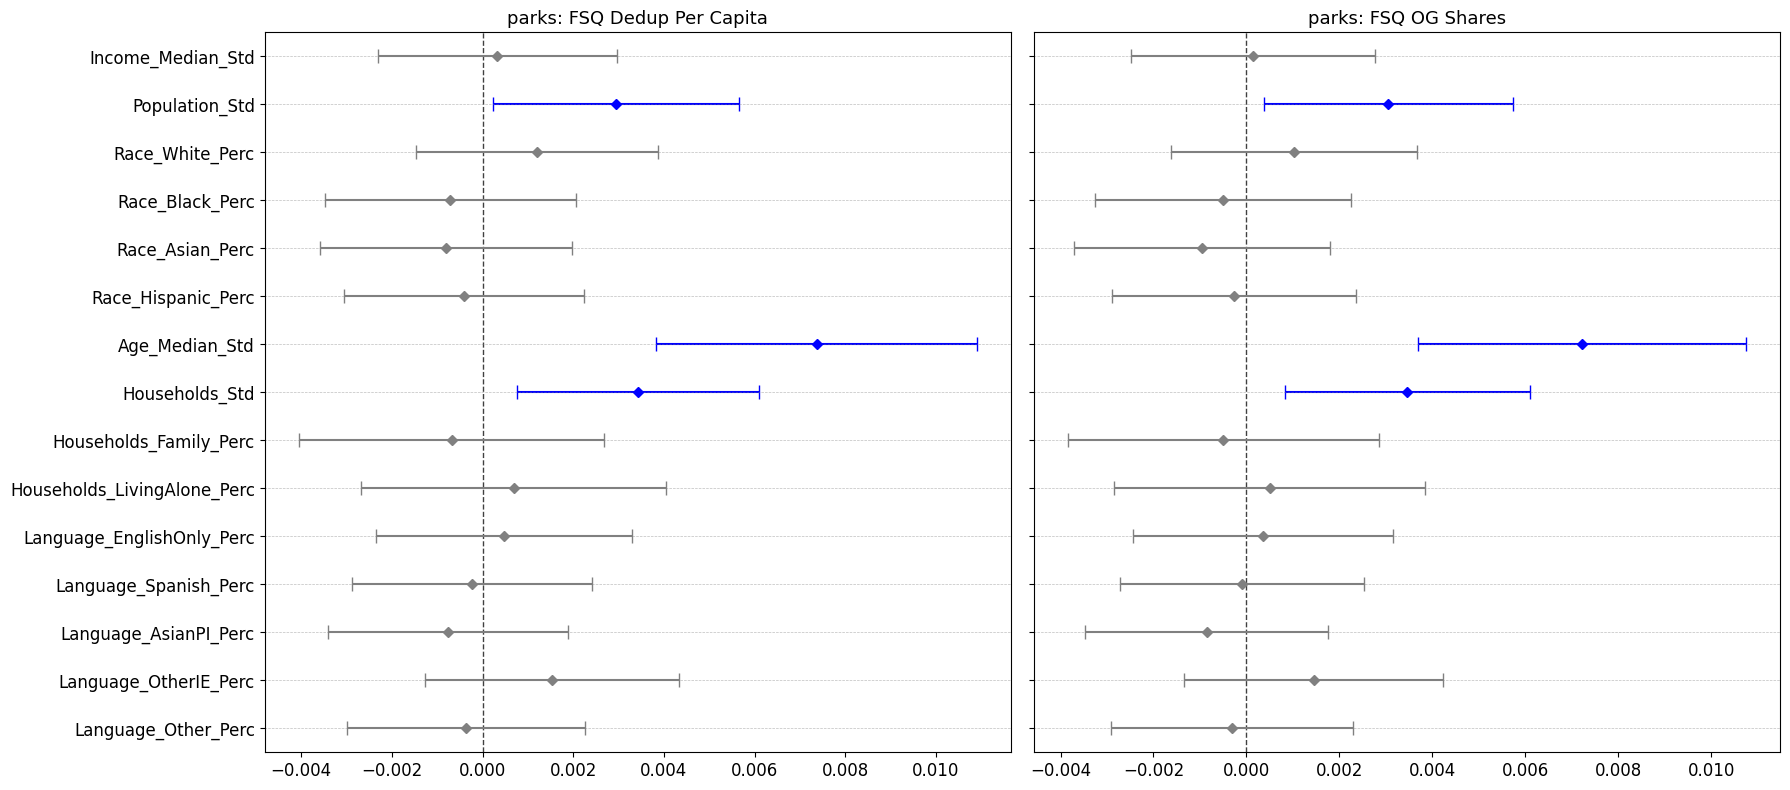

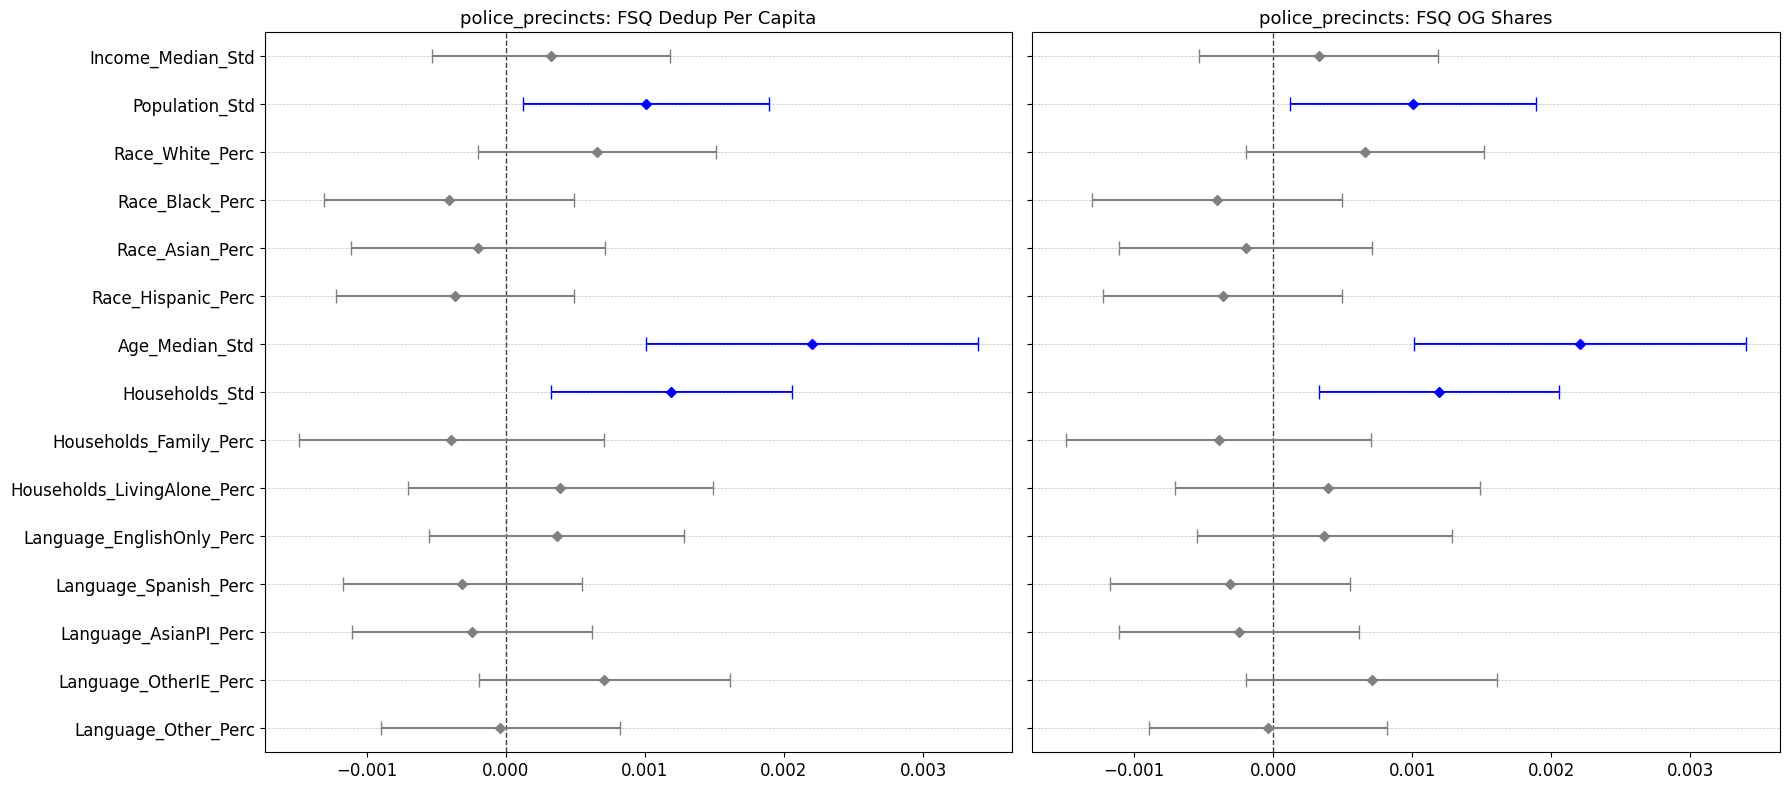

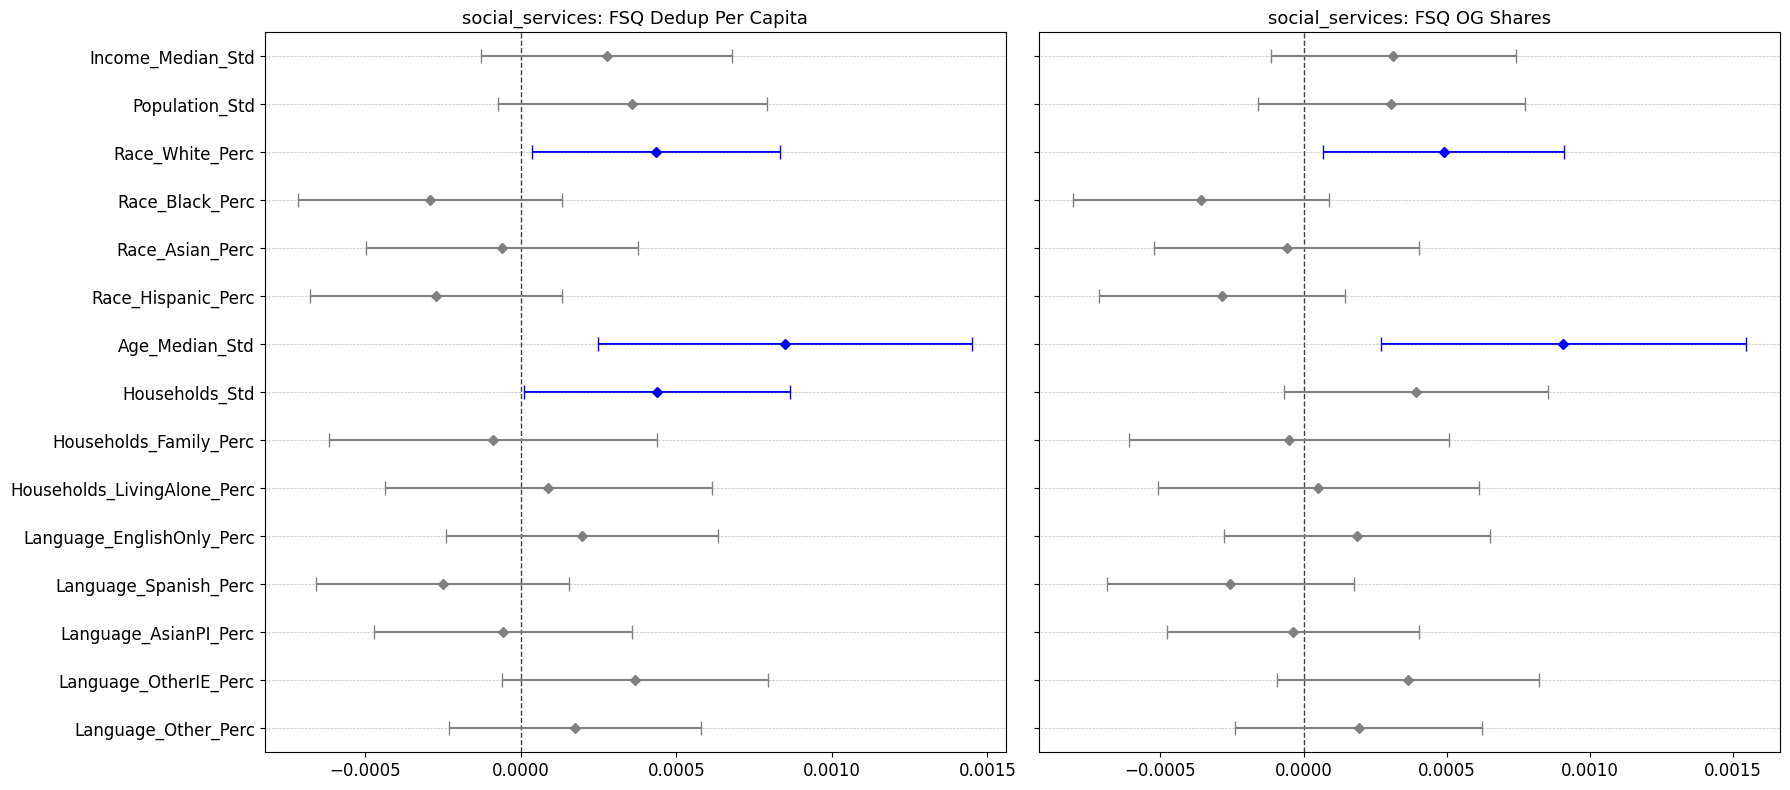

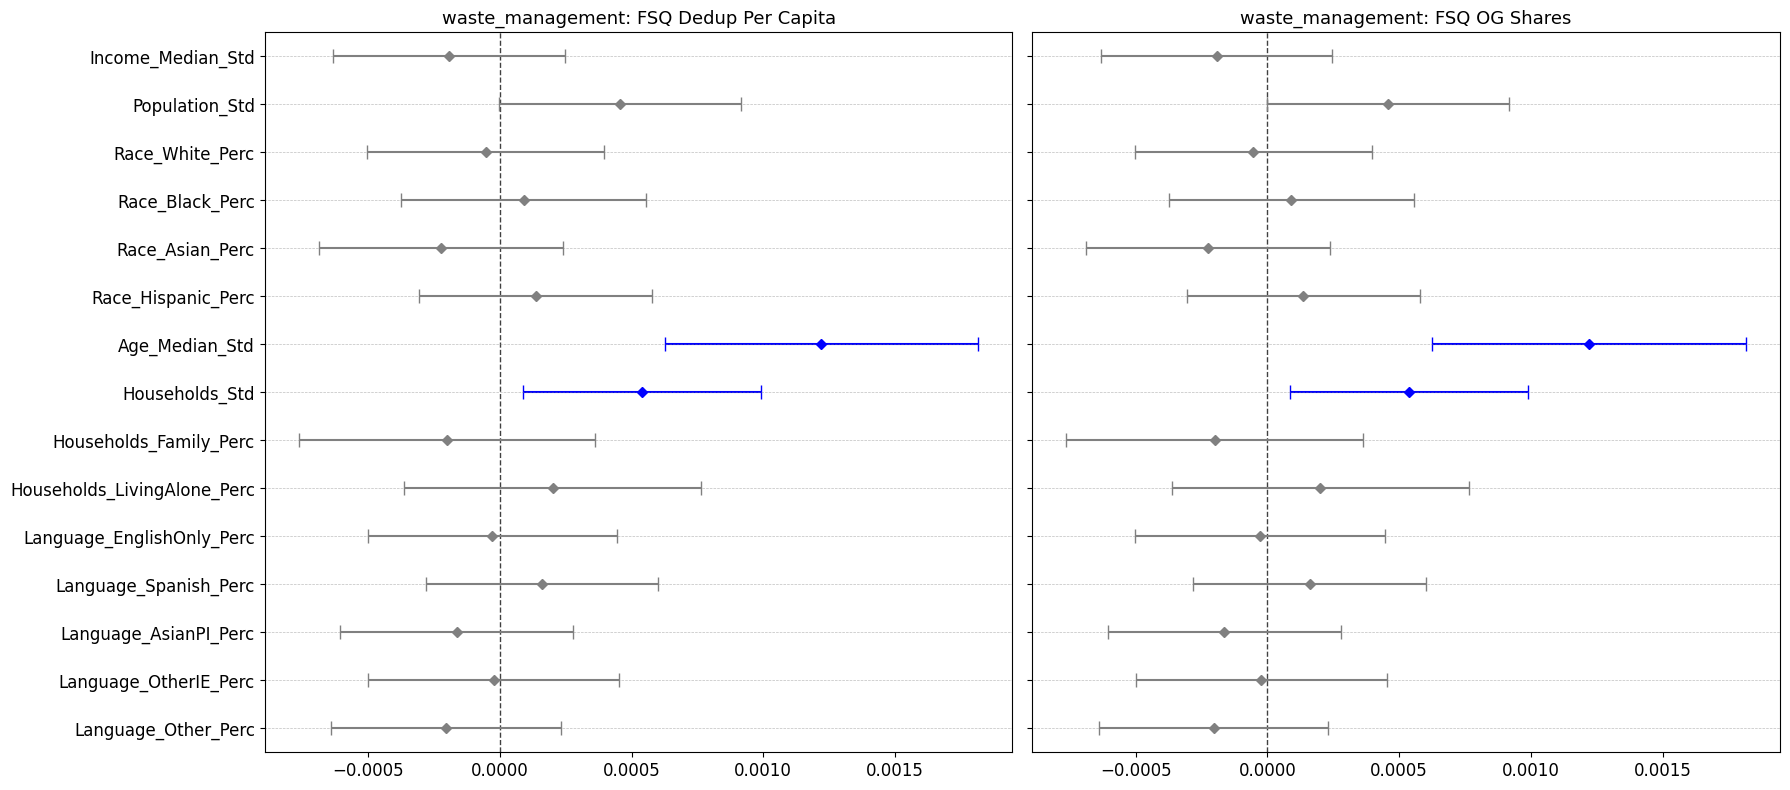

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from matplotlib.patches import Patch
import statsmodels.api as sm

residual_list = []
for cat in counts_pop['lander_category'].unique():
    cat_counts = counts_pop[counts_pop['lander_category'] == cat].copy()

    # x = cat_counts['COUNT(ZBP)']
    # y = cat_counts['COUNT(OG)']
    # z = cat_counts['COUNT(Dedup)']

    # x = cat_counts['ZBP_Share']
    # y = cat_counts['OG_Share']
    # z = cat_counts['Dedup_Share']

    x = cat_counts['ZBP_Per_Capita']
    y = cat_counts['OG_Per_Capita']
    z = cat_counts['Dedup_Per_Capita']
    model_y = sm.GLM(y, sm.add_constant(x), family=sm.families.Gaussian())
    results = model_y.fit()
    y_pred_1 = results.predict(sm.add_constant(x))
    resid_y = y - y_pred_1

    model_z = sm.GLM(z, sm.add_constant(x), family=sm.families.Gaussian())
    results = model_z.fit()
    y_pred_2 = results.predict(sm.add_constant(x))
    resid_z = z - y_pred_2

    temp = pd.DataFrame({
        'zip': cat_counts['zip'].astype(str),
        'category': cat,
        'OG_residual': resid_y,
        'Dedup_residual' : resid_z
    })

    residual_list.append(temp)
residuals_df = pd.concat(residual_list, ignore_index=True)
# residuals_df['Dedup_residual_std'] = residuals_df.groupby('category')['Dedup_residual'].transform(
#     lambda x: StandardScaler().fit_transform(x.values.reshape(-1, 1)).flatten()
# )

from sklearn.preprocessing import StandardScaler

pop = gpd.read_file('/share/garg/dogathon/d01_data/d02_demographics/ZCTA.gpkg')
pop_man = pop[pop['ZCTA'].isin(zips_done)]
pop_man['ZCTA'] = pop_man['ZCTA'].astype(str)
pop_man = pop_man.rename(columns = {'ZCTA': 'zip'})

# Initialize the StandardScaler
scaler = StandardScaler()
# Fit and transform the predictor column
pop_man['Population_Std'] = scaler.fit_transform(pop_man[['Population']])

scaler = StandardScaler()
pop_man['Race_White_Perc'] = pop_man['Race_White'] / pop_man['Population']
pop_man['Race_White_Std'] = scaler.fit_transform(pop_man[['Race_White_Perc']])

scaler = StandardScaler()
pop_man['Race_Black_Perc'] = pop_man['Race_Black'] / pop_man['Population']
pop_man['Race_Black_Std'] = scaler.fit_transform(pop_man[['Race_Black_Perc']])

scaler = StandardScaler()
pop_man['Race_Asian_Perc'] = pop_man['Race_Asian'] / pop_man['Population']
pop_man['Race_Asian_Std'] = scaler.fit_transform(pop_man[['Race_Asian_Perc']])

scaler = StandardScaler()
pop_man['Race_Hispanic_Perc'] = pop_man['Race_Hispanic'] / pop_man['Population']
pop_man['Race_Hispanic_Std'] = scaler.fit_transform(pop_man[['Race_Hispanic_Perc']])

scaler = StandardScaler()
pop_man['Age_Median_Std'] = scaler.fit_transform(pop_man[['Age_Median']])

scaler = StandardScaler()
pop_man['Households_Std'] = scaler.fit_transform(pop_man[['Households']])

scaler = StandardScaler()
pop_man['Households_Family_Perc'] = pop_man['Households_Family'] / pop_man['Households']
pop_man['Households_Family_Std'] = scaler.fit_transform(pop_man[['Households_Family_Perc']])

scaler = StandardScaler()
pop_man['Households_LivingAlone_Perc'] = pop_man['Households_LivingAlone'] / pop_man['Households']
pop_man['Households_LivingAlone_Std'] = scaler.fit_transform(pop_man[['Households_LivingAlone_Perc']])

scaler = StandardScaler()
pop_man['OccupiedHomes_Std'] = scaler.fit_transform(pop_man[['OccupiedHomes']])

scaler = StandardScaler()
pop_man['OccupiedHomes_Renter_Perc'] = pop_man['OccupiedHomes_Renter'] / pop_man['OccupiedHomes']
pop_man['OccupiedHomes_Renter_Std'] = scaler.fit_transform(pop_man[['OccupiedHomes_Renter_Perc']])

scaler = StandardScaler()
pop_man['Language_Total_Std'] = scaler.fit_transform(pop_man[['Language_Total']])

scaler = StandardScaler()
pop_man['Language_EnglishOnly_Perc'] = pop_man['Language_EnglishOnly'] / pop_man['Language_Total']
pop_man['Language_EnglishOnly_Std'] = scaler.fit_transform(pop_man[['Language_EnglishOnly_Perc']])

scaler = StandardScaler()
pop_man['Language_Spanish_Perc'] = pop_man['Language_Spanish'] / pop_man['Language_Total']
pop_man['Language_Spanish_Std'] = scaler.fit_transform(pop_man[['Language_Spanish_Perc']])

scaler = StandardScaler()
pop_man['Language_AsianPI_Perc'] = pop_man['Language_AsianPI'] / pop_man['Language_Total']
pop_man['Language_AsianPI_Std'] = scaler.fit_transform(pop_man[['Language_AsianPI_Perc']])

scaler = StandardScaler()
pop_man['Language_OtherIE_Perc'] = pop_man['Language_OtherIE'] / pop_man['Language_Total']
pop_man['Language_OtherIE_Std'] = scaler.fit_transform(pop_man[['Language_OtherIE_Perc']])

scaler = StandardScaler()
pop_man['Language_Other_Perc'] = pop_man['Language_Other'] / pop_man['Language_Total']
pop_man['Language_Other_Std'] = scaler.fit_transform(pop_man[['Language_Other_Perc']])

scaler = StandardScaler()
pop_man['Income_Median_Std'] = scaler.fit_transform(pop_man[['Income_Median']])



# %%
# Merge with all demographic predictors
merged_df = pd.merge(residuals_df, pop_man, on='zip', how='left')

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import seaborn as sns
import matplotlib.pyplot as plt

demographics_to_plot = ['Income_Median_Std', 'Population_Std', 'Race_White_Perc', 'Race_Black_Perc',
       'Race_Asian_Perc', 'Race_Hispanic_Perc', 'Age_Median_Std','Households_Std', 
       'Households_Family_Perc', 'Households_LivingAlone_Perc', 
       'Language_EnglishOnly_Perc',
       'Language_Spanish_Perc',
       'Language_AsianPI_Perc',
       'Language_OtherIE_Perc',
       'Language_Other_Perc'
       ]

demographics_to_plot_na = ['Median_Income_Std']

lander_categories = ['childcare', 'fire_stations', 'homeless_shelters', 'parks',
                     'police_precincts', 'social_services', 'waste_management']

# for demo in demographics_to_plot:
#     # Precompute R² values per category
#     df_demo = merged_df[~merged_df[demo].isna()]
#     r2_dict = {}

#     for cat in df_demo['category'].unique():
#         subset = df_demo[df_demo['category'] == cat]
#         x = subset[[demo]].values
#         y = subset['Dedup_residual_std'].values

#         if len(x) > 1:  # Ensure enough points
#             model = LinearRegression()
#             model.fit(x, y)
#             y_pred = model.predict(x)
#             r2 = r2_score(y, y_pred)
#             r2_dict[cat] = r2
#         else:
#             r2_dict[cat] = None

    # Plot
    # g = sns.FacetGrid(df_demo, col="category", col_wrap=3, height=4, sharex=False, sharey=True)
    # g.map_dataframe(sns.scatterplot, x=demo, y="Dedup_residual", alpha=0.6)
    # g.map_dataframe(sns.regplot, x=demo, y="Dedup_residual", scatter=False, lowess=True, line_kws={"color": "red"})

    # Annotate each subplot with R²
    # for ax in g.axes.flatten():
    #     title = ax.get_title()
    #     cat = title.split('=')[-1].strip()
    #     r2 = r2_dict.get(cat, None)
    #     if r2 is not None:
    #         ax.text(0.05, 0.95, f"R² = {r2:.2f}", transform=ax.transAxes,
    #                 verticalalignment='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray'))

    # g.set_titles("{col_name}")
    # g.set_axis_labels(demo, "Residual (Dedup - Predicted)")
    # plt.subplots_adjust(top=0.9)
    # g.fig.suptitle(f"Residuals of Dedup Shares vs {demo}", fontsize=16)
    # plt.show()

from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

def plot_CIs_covariates(CIs_df, crop_plots=True, ax=None, figsize=(6, 6),
                        covariate_names=None, show=True, ylabel_size=12,
                        xlabel_size=12,
                        color_CIs_by_significance=True, fill_between=False, horizontal_lines=True):
    
    if ax is None: fig, ax = plt.subplots(figsize=figsize)
    
    CIs_df = CIs_df.replace({'-':np.nan}).dropna()
    if covariate_names is None: covariate_names = CIs_df.index.values
    
    estimates = CIs_df.loc[covariate_names, 'Estimate'].values
    UB = CIs_df.loc[covariate_names, 'Upper bound'].values
    LB = CIs_df.loc[covariate_names, 'Lower bound'].values
    CIs = np.vstack([estimates-LB, UB-estimates])

    #Collect colors:
    if color_CIs_by_significance:
        colors = ['red' if ub < 0 else ('blue' if lb > 0 else 'grey')
                 for ub, lb in list(zip(UB, LB))]
    else:
        colors = ['black']*len(estimates)

    #Plot:
    for estimate, name, CI, color in zip(estimates[::-1],
                                         covariate_names[::-1],
                                         CIs[::, ::-1].T,
                                         colors[::-1]):
        _ = ax.errorbar(x=estimate,
                        y=name,
                        xerr=CI.reshape(2,1),
                        ecolor=color,
                        capsize=5,
                        linestyle='None',
                        linewidth=1.5,
                        marker="D",
                        markersize=5,
                        mfc=color,
                        mec=color)

    ax.tick_params(axis='y', labelsize=ylabel_size)
    ax.tick_params(axis='x', labelsize=xlabel_size)
    #Grids:
    xlim = ax.get_xlim()
    _ = ax.axvline(0, linestyle='--', color='black', alpha=0.75, zorder=-1, linewidth=1.)

    #for val in [0.5, 1, 1.5, 2]:
    #    if xlim[1] > val: _ = ax.axvline(val, linestyle='-', color='lightgrey', alpha=0.5, zorder=-1, linewidth=1)
    #for val in [-0.5, -1, -1.5, -2]:
    #    if xlim[0] < val: _ = ax.axvline(val, linestyle='-', color='lightgrey', alpha=0.5, zorder=-1, linewidth=1)

    #Fill between:
    if fill_between:
        #Home ownership:
        _ = ax.fill_between(np.linspace(xlim[0], xlim[1], 1000, endpoint=True), -0.5, 1.5, alpha=.4, color='lightgrey', linewidth=0)
        #Education:
        _ = ax.fill_between(np.linspace(xlim[0], xlim[1], 1000, endpoint=True), 6.5, 8.5, alpha=.4, color='lightgrey', linewidth=0)
        #Demographics:
        _ = ax.fill_between(np.linspace(xlim[0], xlim[1], 1000, endpoint=True), 10.5, 14.5, alpha=.4, color='lightgrey', linewidth=0)
    if horizontal_lines:
        for y, c in enumerate(colors[::-1]):
            _ = ax.hlines(y=y, xmin=-3, xmax=3, linestyle='--', linewidth=0.5, alpha=0.5, color='grey')
    _ = ax.set_xlim(xlim)
    _ = ax.set_ylim(-0.5, len(estimates)-0.5)
            
    if show: plt.show()
        
    return ax

def get_ci_df(X, y, covariate_names):
    X_const = sm.add_constant(X)
    model = sm.OLS(y, X_const).fit()
    estimates = model.params[1:]  # skip intercept
    conf = model.conf_int().ilox-c[1:]  # skip intercept
    return pd.DataFrame({
        "Estimate": estimates.values,
        "Lower bound": conf[0].values,
        "Upper bound": conf[1].values
    }, index=covariate_names)


def get_univariate_ci_df(X_df, y_series):
    ci_list = []
    for col in X_df.columns:
        x = sm.add_constant(X_df[[col]])
        model = sm.OLS(y_series, x).fit()
        est = model.params[col]
        conf = model.conf_int().loc[col]
        ci_list.append({
            "Estimate": est,
            "Lower bound": conf[0],
            "Upper bound": conf[1]
        })
    return pd.DataFrame(ci_list, index=X_df.columns)

# Set up once
covariate_cols = demographics_to_plot  # your list of demographic column names
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(pop_man[covariate_cols]), columns=covariate_cols)
X_scaled['zip'] = df_all_zips['zip']  # make sure zip aligns for merging
# print(X_scaled[X_scaled['Income_Median_Std'].isna()])

residuals_og = merged_df['OG_residual']
residuals_dedup = merged_df['Dedup_residual']

# Loop over each category
for cat in lander_categories:
    residuals_cat = residuals_df[residuals_df['category'] == cat]
    # Merge X and residuals
    df_cat = pd.DataFrame({
        'zip': (df_all_zips[df_all_zips['lander_category'] == cat]['zip']).values,
        'OG_residual': residuals_cat['OG_residual'].values,
        'Dedup_residual': residuals_cat['Dedup_residual'].values,
    })
    merged = df_cat.merge(X_scaled, on='zip', how='inner')
    # print(merged[merged['Dedup_residual'].isna()])
    # X = merged[covariate_cols]
    merged_clean = merged.dropna(subset=covariate_cols + ['OG_residual', 'Dedup_residual'])
    X = merged_clean[covariate_cols]

    # Compute CI DataFrames
    # ci_og = get_ci_df(X, merged_clean['OG_residual'], covariate_cols)
    ci_og = get_univariate_ci_df(X, merged_clean['OG_residual'])
    # ci_dedup = get_ci_df(X, merged_clean['Dedup_residual'], covariate_cols)
    ci_dedup = get_univariate_ci_df(X, merged_clean['Dedup_residual'])
    # Plot them
    fig, axs = plt.subplots(1, 2, figsize=(18, len(covariate_cols)*0.4 + 2), sharey=True)
    plot_CIs_covariates(ci_og, ax=axs[1], show=False)
    axs[1].set_title(f"{cat}: FSQ OG Shares", fontsize=13)

    plot_CIs_covariates(ci_dedup, ax=axs[0], show=False)
    axs[0].set_title(f"{cat}: FSQ Dedup Per Capita", fontsize=13)
    plt.tight_layout()
    plt.show()


<Axes: >

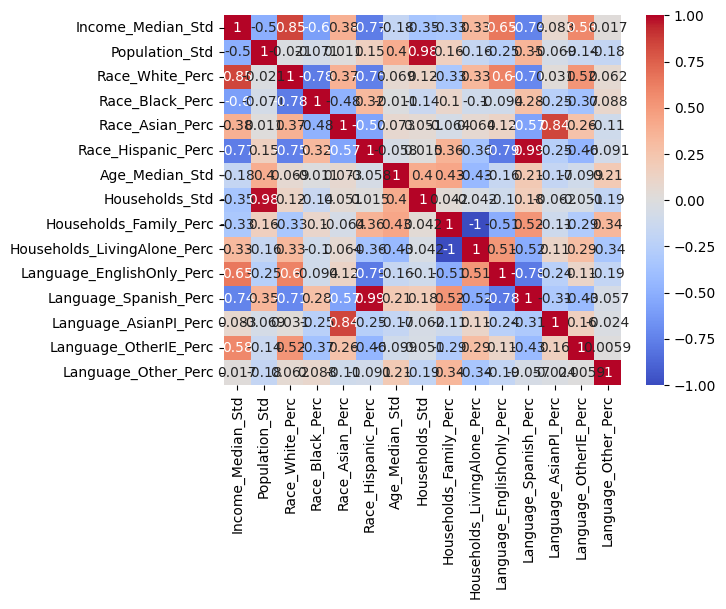

In [13]:
import seaborn as sns
sns.heatmap(X_scaled[covariate_cols].corr(), annot=True, cmap='coolwarm')

In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_with_const = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i+1) for i in range(X.shape[1])]
print(vif_data)

                        feature          VIF
0             Income_Median_Std    13.546357
1                Population_Std    95.440440
2               Race_White_Perc  1563.331748
3               Race_Black_Perc   781.175434
4               Race_Asian_Perc   279.332291
5            Race_Hispanic_Perc  1210.003770
6                Age_Median_Std     2.974609
7                Households_Std    98.295265
8        Households_Family_Perc          inf
9   Households_LivingAlone_Perc          inf
10    Language_EnglishOnly_Perc          inf
11        Language_Spanish_Perc          inf
12        Language_AsianPI_Perc          inf
13        Language_OtherIE_Perc          inf
14          Language_Other_Perc          inf


/share/garg/conda_virtualenvs/wildfires/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [67]:
zip_gdf = gpd.read_file("/share/garg/accessgaps2024/fsq_cleaning/data/tl_2020_us_zcta520/tl_2020_us_zcta520.shp")
zip_gdf = zip_gdf.rename(columns = {"ZCTA5CE20": "zip"})
zip_nyc_gdf = zip_gdf[zip_gdf['zip'].astype(int).isin(zips_done)]
zip_nyc_gdf['zip'] = zip_nyc_gdf['zip'].astype(str)
zip_nyc_gdf = zip_nyc_gdf.set_index('zip')
zip_nyc_gdf

/share/garg/conda_virtualenvs/wildfires/lib/python3.9/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


GEOID20 CLASSFP20 MTFCC20 FUNCSTAT20  ALAND20  AWATER20   INTPTLAT20  \
zip                                                                          
10005   10005        B5   G6350          S   188727         0  +40.7062151   
10170   10170        B5   G6350          S    24921         0  +40.7526253   
10173   10173        B5   G6350          S    12297         0  +40.7541306   
10282   10282        B5   G6350          S   177847         0  +40.7163808   
10044   10044        B5   G6350          S   595879         0  +40.7619065   
10103   10103        B5   G6350          S    24776         0  +40.7607797   
10162   10162        B5   G6350          S    33146         0  +40.7692674   
10119   10119        B5   G6350          S    65943         0  +40.7506440   
10199   10199        B5   G6350          S    65414         0  +40.7513831   
10003   10003        B5   G6350          S  1480445         0  +40.7318636   
10004   10004        B5   G6350          S  1179938         0  +40.6898053   
10006   10006        B5   G6350          S   250630         0  +40.7094897   
10007   10007        B5   G6350          S   414129         0  +40.7138682   
10009   10009        B5   G6350          S  1597304         0  +40.7263919   
10010   10010        B5   G6350          S   955081         0  +40.7390445   
10011   10011        B5   G6350          S  1677161         0  +40.7418410   
10012   10012        B5   G6350          S   839030         0  +40.7256254   
10013   10013        B5   G6350          S  1409917         0  +40.7200512   
10014   10014        B5   G6350          S  1255850         0  +40.7341455   
10016   10016        B5   G6350          S  1423936         0  +40.7451856   
10017   10017        B5   G6350          S   771547         0  +40.7523960   
10018   10018        B5   G6350          S   891039         0  +40.7553269   
10019   10019        B5   G6350          S  1706504     17866  +40.7657350   
10021   10021        B5   G6350          S   923484         0  +40.7696389   
10022   10022        B5   G6350          S  1148424         0  +40.7585663   
10023   10023        B5   G6350          S  2510429     95089  +40.7745673   
10024   10024        B5   G6350          S  2292582    404929  +40.7856602   
10025   10025        B5   G6350          S  2302133         0  +40.7982514   
10026   10026        B5   G6350          S   992725         0  +40.8029777   
10027   10027        B5   G6350          S  2440914      1032  +40.8126570   
10028   10028        B5   G6350          S   819923         0  +40.7764478   
10029   10029        B5   G6350          S  2987117     49222  +40.7922493   
10030   10030        B5   G6350          S   718112         0  +40.8182473   
10031   10031        B5   G6350          S  1733068         0  +40.8248037   
10032   10032        B5   G6350          S  1742138         0  +40.8390405   
10033   10033        B5   G6350          S  1544802         0  +40.8474756   
10034   10034        B5   G6350          S  2648152     11193  +40.8670761   
10035   10035        B5   G6350          S  3638045         0  +40.7952510   
10036   10036        B5   G6350          S  1158340         0  +40.7597915   
10037   10037        B5   G6350          S   602984         0  +40.8130268   
10038   10038        B5   G6350          S   747572         0  +40.7092638   
10039   10039        B5   G6350          S   774862         0  +40.8262869   
10040   10040        B5   G6350          S  1468523         0  +40.8580974   
10065   10065        B5   G6350          S  1085419         0  +40.7646840   
10069   10069        B5   G6350          S   106197         0  +40.7773824   
10075   10075        B5   G6350          S   489565         0  +40.7734071   
10128   10128        B5   G6350          S  1173140         0  +40.7815010   
10165   10165        B5   G6350          S    13058         0  +40.7521310   
10001   10001        B5   G6350          S  1615692         0  +40.7506496   
10002   10002        B5   G6

In [68]:
residuals_df

zip          category  OG_residual  Dedup_residual  Dedup_residual_std
0    10001         childcare     0.032760        0.035660            0.222142
1    10002         childcare     0.024611        0.023795            0.148226
2    10003         childcare     0.085413        0.088664            0.552323
3    10004         childcare    -0.180149       -0.201552           -1.255544
4    10005         childcare    -0.029422       -0.062801           -0.391213
..     ...               ...          ...             ...                 ...
359  10173  waste_management    -0.017288       -0.017491           -0.597389
360  10199  waste_management    -0.017288       -0.017491           -0.597389
361  10279  waste_management    -0.017288       -0.017491           -0.597389
362  10280  waste_management    -0.017288       -0.017491           -0.597389
363  10282  waste_management    -0.017288       -0.017491           -0.597389

[364 rows x 5 columns]

['10001', '10002', '10003', '10004', '10005', '10006', '10007', '10009', '10010', '10011', '10012', '10013', '10014', '10016', '10017', '10018', '10019', '10021', '10022', '10023', '10024', '10025', '10026', '10027', '10028', '10029', '10030', '10031', '10032', '10033', '10034', '10035', '10036', '10037', '10038', '10039', '10040', '10044', '10065', '10069', '10075', '10103', '10119', '10128', '10162', '10165', '10170', '10173', '10199', '10279', '10280', '10282']


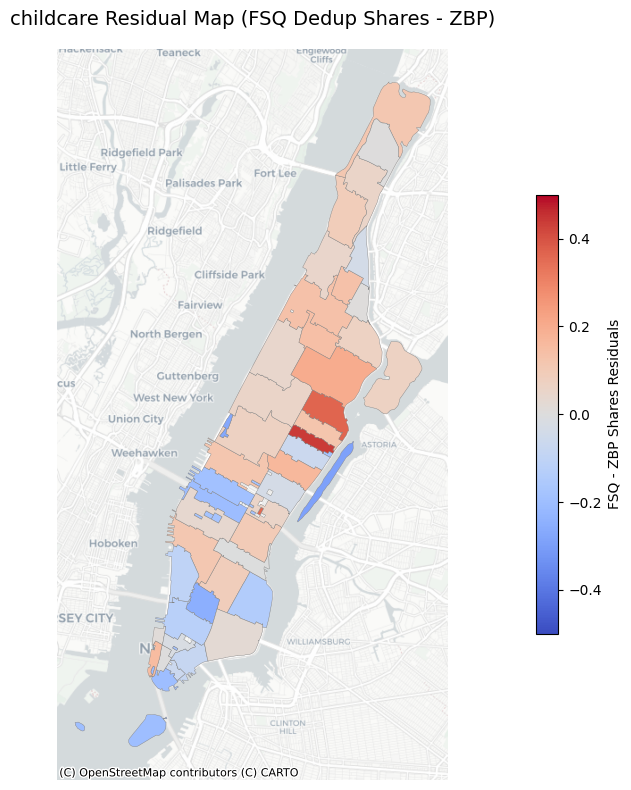

['10001', '10002', '10003', '10004', '10005', '10006', '10007', '10009', '10010', '10011', '10012', '10013', '10014', '10016', '10017', '10018', '10019', '10021', '10022', '10023', '10024', '10025', '10026', '10027', '10028', '10029', '10030', '10031', '10032', '10033', '10034', '10035', '10036', '10037', '10038', '10039', '10040', '10044', '10065', '10069', '10075', '10103', '10119', '10128', '10162', '10165', '10170', '10173', '10199', '10279', '10280', '10282']


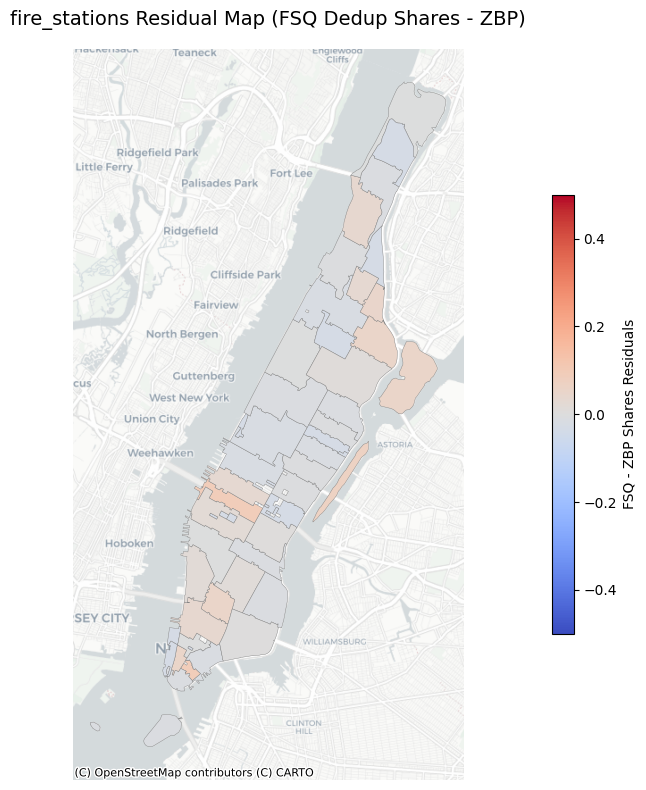

['10001', '10002', '10003', '10004', '10005', '10006', '10007', '10009', '10010', '10011', '10012', '10013', '10014', '10016', '10017', '10018', '10019', '10021', '10022', '10023', '10024', '10025', '10026', '10027', '10028', '10029', '10030', '10031', '10032', '10033', '10034', '10035', '10036', '10037', '10038', '10039', '10040', '10044', '10065', '10069', '10075', '10103', '10119', '10128', '10162', '10165', '10170', '10173', '10199', '10279', '10280', '10282']


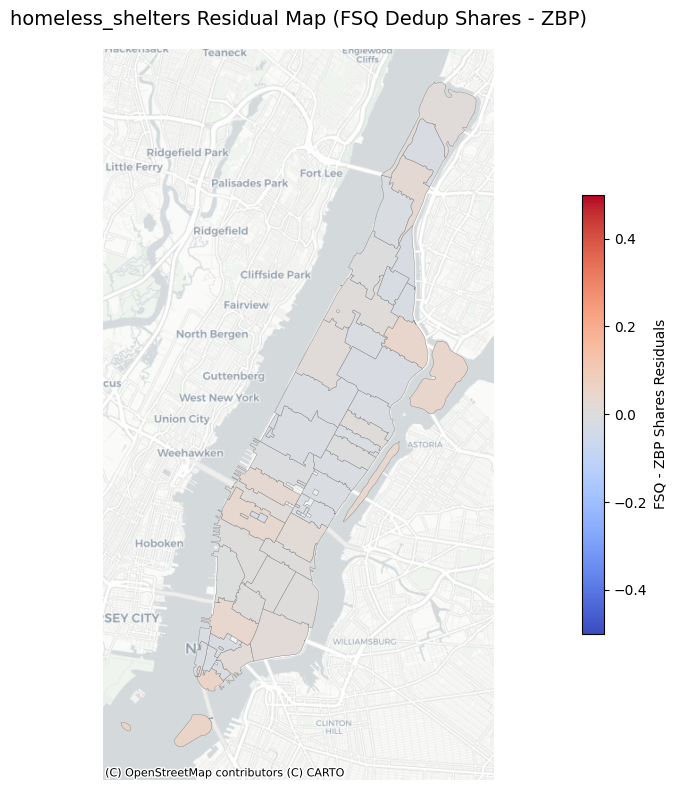

['10001', '10002', '10003', '10004', '10005', '10006', '10007', '10009', '10010', '10011', '10012', '10013', '10014', '10016', '10017', '10018', '10019', '10021', '10022', '10023', '10024', '10025', '10026', '10027', '10028', '10029', '10030', '10031', '10032', '10033', '10034', '10035', '10036', '10037', '10038', '10039', '10040', '10044', '10065', '10069', '10075', '10103', '10119', '10128', '10162', '10165', '10170', '10173', '10199', '10279', '10280', '10282']


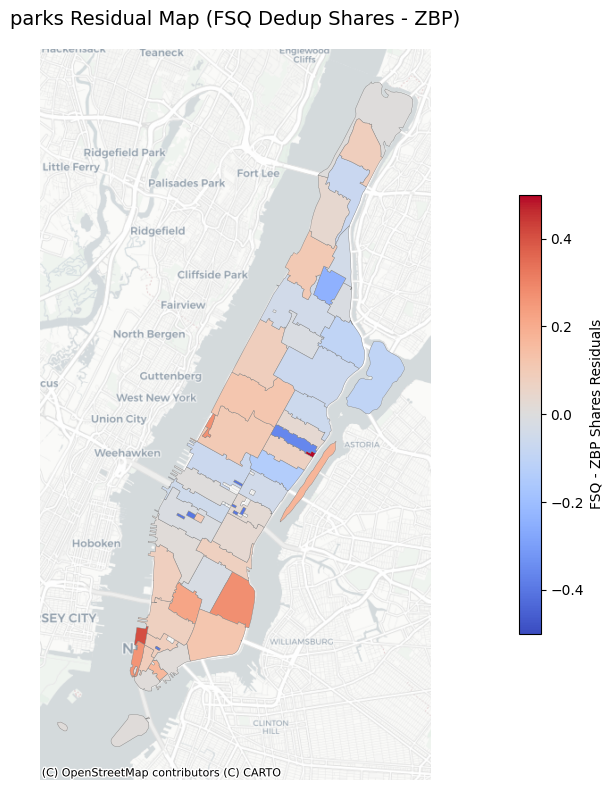

['10001', '10002', '10003', '10004', '10005', '10006', '10007', '10009', '10010', '10011', '10012', '10013', '10014', '10016', '10017', '10018', '10019', '10021', '10022', '10023', '10024', '10025', '10026', '10027', '10028', '10029', '10030', '10031', '10032', '10033', '10034', '10035', '10036', '10037', '10038', '10039', '10040', '10044', '10065', '10069', '10075', '10103', '10119', '10128', '10162', '10165', '10170', '10173', '10199', '10279', '10280', '10282']


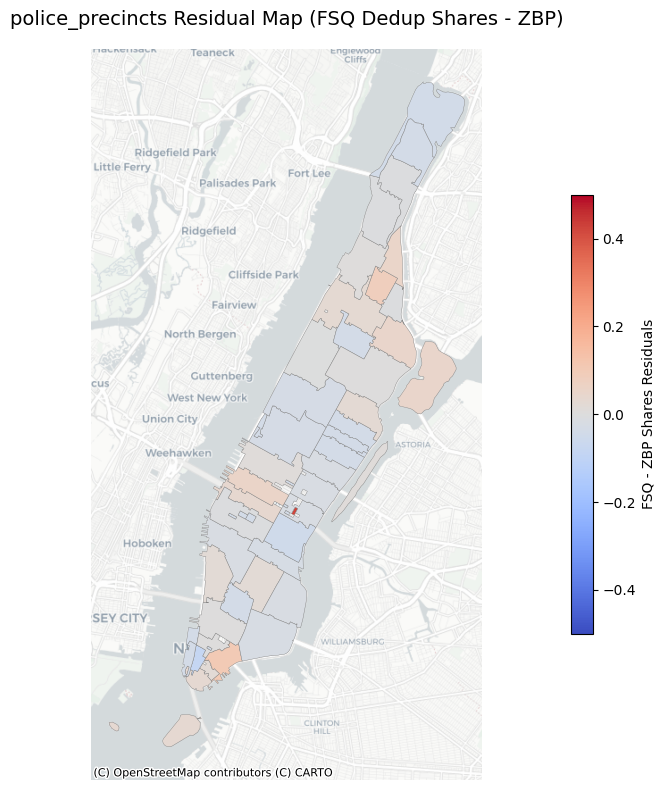

['10001', '10002', '10003', '10004', '10005', '10006', '10007', '10009', '10010', '10011', '10012', '10013', '10014', '10016', '10017', '10018', '10019', '10021', '10022', '10023', '10024', '10025', '10026', '10027', '10028', '10029', '10030', '10031', '10032', '10033', '10034', '10035', '10036', '10037', '10038', '10039', '10040', '10044', '10065', '10069', '10075', '10103', '10119', '10128', '10162', '10165', '10170', '10173', '10199', '10279', '10280', '10282']


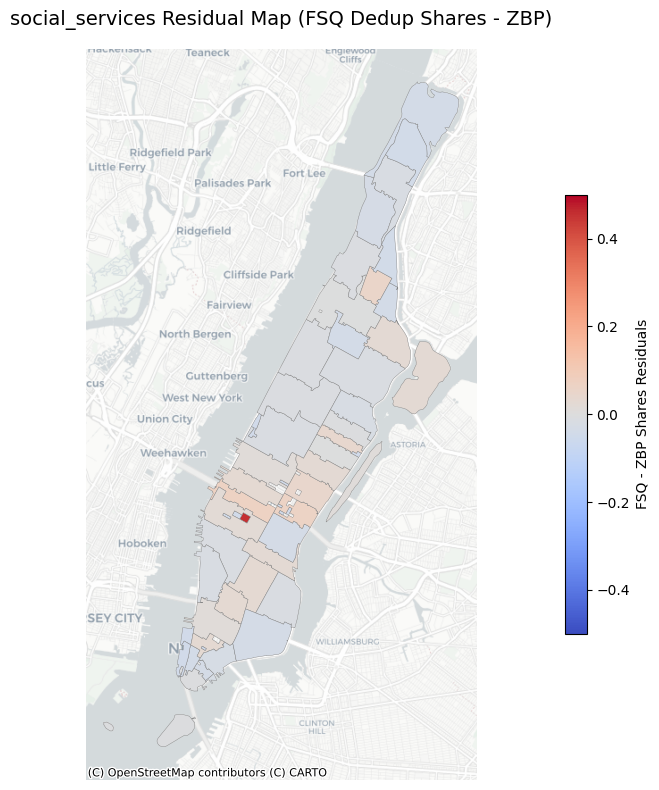

['10001', '10002', '10003', '10004', '10005', '10006', '10007', '10009', '10010', '10011', '10012', '10013', '10014', '10016', '10017', '10018', '10019', '10021', '10022', '10023', '10024', '10025', '10026', '10027', '10028', '10029', '10030', '10031', '10032', '10033', '10034', '10035', '10036', '10037', '10038', '10039', '10040', '10044', '10065', '10069', '10075', '10103', '10119', '10128', '10162', '10165', '10170', '10173', '10199', '10279', '10280', '10282']


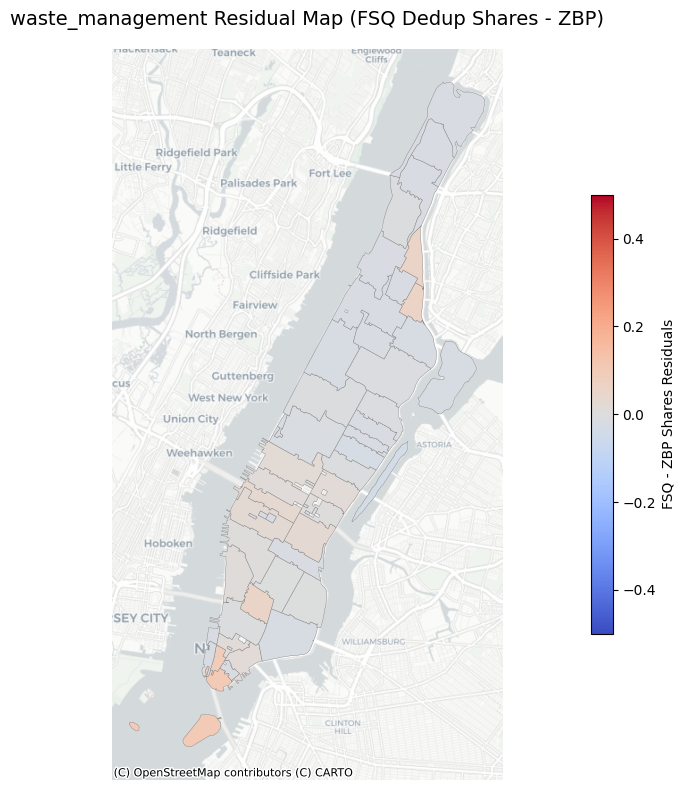

In [70]:
import contextily as ctx


residuals_df['Dedup_residual_std'] = residuals_df.groupby('category')['Dedup_residual'].transform(
    lambda x: StandardScaler().fit_transform(x.values.reshape(-1, 1)).flatten()
)

for cat in residuals_df['category'].unique():
    cat_joined = zip_nyc_gdf.merge(residuals_df[residuals_df['category'] == cat], on = 'zip', how = 'left')
    print(sorted(cat_joined['zip'].unique()))
    residual_col = 'Dedup_residual'

    # Set up diverging colormap around 0
    vmin = -max(abs(cat_joined[residual_col].min()), abs(cat_joined[residual_col].max()))
    vmax = -vmin
    fig_height = max(len(covariate_cols) * 0.4 + 2, 6)
    fig, axs = plt.subplots(figsize=(18, fig_height), sharey=True)
    cat_joined = cat_joined.to_crs(epsg=3857)
    # zip_nyc_gdf = zip_nyc_gdf.to_crs(epsg=3857)

    cat_joined.plot(
        column=residual_col,
        cmap='coolwarm',  # or 'RdBu', 'bwr'
        linewidth=0.3,
        ax=axs,
        edgecolor='grey',
        legend=True,
        legend_kwds={
            'label': "FSQ - ZBP Shares Residuals",
            'shrink': 0.6,
            'orientation': 'vertical'
        },
        vmin = -0.5,
        vmax = 0.5
        # vmin=-170,
        # vmax=170,
    )
    axs.set_title(f"{cat} Residual Map (FSQ Dedup Shares - ZBP)", fontsize=14)
    axs.axis('off')

    ctx.add_basemap(axs, source=ctx.providers.CartoDB.Positron)

    # plot_CIs_covariates(ci_dedup, ax=axs[1], show=False)
    # axs[1].set_title(f"{cat}: FSQ Dedup", fontsize=13)

    # cat_joined.plot(
    #     column=residual_col,
    #     cmap='coolwarm',  # or 'RdBu', 'bwr'
    #     linewidth=0.3,
    #     ax=axs[1],
    #     edgecolor='grey',
    #     legend=True,
    #     legend_kwds={
    #         'label': "FSQ - ZBP Shares Residuals",
    #         'shrink': 0.6,
    #         'orientation': 'vertical'
    #     },
    #     vmin=vmin,
    #     vmax=-vmin,
    # )
    plt.tight_layout()
    plt.show()


